# AffectiveROAD Results on XGBoost + Hyperopt

Code & Results for all combinations of extracted Features for AffectiveROAD

* [Imports & Helper Functions](#section-one)
* [# Physiological Signals Model Results](#section-two)
    - [BVP Binary](#subsection-one)
    - [EDA Binary](#subsection-two)
    - [Skin Temperature Binary](#subsection-three)
    - [BVP+GSR Binary](#subsection-four)
    - [BVP+ST Binary](#subsection-five)
    - [GSR + ST Binary](#subsection-six)
    - [BVP+ GSR+ST Binary](#subsection-seven)


<a id="section-one"></a>
# Imports & Helper Functions




In [1]:
import os
import sys
import csv

#median
import statistics
from statistics import median

import os
from glob import glob

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# Autosklearn
# import autosklearn.classification
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.metrics



import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',100000)


from sklearn.datasets import make_classification
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import  accuracy_score, auc, classification_report, precision_recall_curve, precision_score,roc_curve,roc_auc_score, recall_score, f1_score


In [2]:
import optuna
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import xgboost as xgb
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit


from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from yellowbrick.classifier import ROCAUC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import TimeSeriesSplit


from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy
from sklearn.model_selection import cross_val_score
from joblib import dump, load
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
from lightgbm import LGBMClassifier



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [4]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [5]:
space={
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 42
    }

In [6]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),verbosity=0)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
#     print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [7]:
  
def ROCCuruve_custom(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf):
    y_pred_prob = xgboost_hyperpot_clf.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Train Data ROC Curve')
    plt.show()
    y_pred_prob = xgboost_hyperpot_clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Data ROC Curve')
    plt.show()
def cm(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf):
    train_pred = xgboost_hyperpot_clf.predict(X_train)
    test_pred = xgboost_hyperpot_clf.predict(X_test)
#     print("Train Confusion matrix \n")
    plot_cm(y_train,train_pred)
#     print("Test Confusion matrix \n")
    plot_cm(y_test,test_pred)
def classifiermodelresult_binary(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf):
    import time
    lst_y_test = []
    for i in range(len(y_test)):

      lst_y_test.append(y_test.iloc[i])

    lst_y_test


#     xgb.plot_importance(xgboost_hyperpot_clf)


    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    train_pred = xgboost_hyperpot_clf.predict(X_train)
    test_pred = xgboost_hyperpot_clf.predict(X_test)
    print("Train Accuracy Score After 10 K Fold CV", sklearn.metrics.accuracy_score(y_train, train_pred))
    print("Test Accuracy Score After 10 K Fold CV\n\n", sklearn.metrics.accuracy_score(y_test, test_pred))
    print("Train Report:  \n",classification_report(y_train,train_pred))
    print("Test Report:  \n",classification_report(y_test,test_pred))
     
    
    
  

    
    precisions, recalls, thresholds = precision_recall_curve(y_train, train_pred)

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")

    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.show()
    precisions, recalls, thresholds = precision_recall_curve(y_test, test_pred)

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")

    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.show()
#     time.sleep(10)
    print("Train Log Loss: ", log_loss(y_train,train_pred))
    print("Test Log Loss: ", log_loss(y_test,test_pred))
    

In [8]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_train, y_train,cv=10,n_jobs=-1).mean()
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}
def fknn(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

def knnhyperopt(X_train, y_train,X_test,y_test):
    trials = Trials()
    best = fmin(fknn, space4knn, algo=tpe.suggest, max_evals=150, trials=trials)
    print ('best:')
    print (best)
    if(best['n_neighbors']==0):
        best['n_neighbors']=1
    xgboost_hyperpot_clf = KNeighborsClassifier(**best)
    xgboost_hyperpot_clf.fit(X_train, y_train)
    train_pred = xgboost_hyperpot_clf.predict(X_train)
    test_pred = xgboost_hyperpot_clf.predict(X_test)
    print("Train Accuracy KNN", sklearn.metrics.accuracy_score(y_train, train_pred))
    print("Test Accuracy KNN", sklearn.metrics.accuracy_score(y_test, test_pred),"\n")
    accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_train, y = y_train, cv = 10)
    print("Accuracies Train KNN:\n", accuracies)
    print("Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN", accuracies.mean())
    print("Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN", accuracies.std(),"\n")
    accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_test, y = y_test, cv = 10)
    print("Accuracies Test KNN:\n", accuracies)
    print("Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN", accuracies.mean())
    print("Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN", accuracies.std(),"\n")
    classifiermodelresult_binary(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    ROCCuruve_custom(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    cm(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    return xgboost_hyperpot_clf

    
    

In [9]:


def xgboosthyperopt(X_train, y_train,X_test,y_test):
    trials = Trials()
    warnings.filterwarnings("ignore")

    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 150,
                            trials = trials)
    best_hyperparams['max_depth'] = (int)(best_hyperparams['max_depth'])
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams,"\n")
    xgboost_hyperpot_clf = xgb.XGBClassifier(**best_hyperparams)
    xgboost_hyperpot_clf.fit(X_train, y_train)
    train_pred = xgboost_hyperpot_clf.predict(X_train)
    test_pred = xgboost_hyperpot_clf.predict(X_test)
    print("Train Accuracy XGBoost", sklearn.metrics.accuracy_score(y_train, train_pred))
    print("Test Accuracy XGBoost", sklearn.metrics.accuracy_score(y_test, test_pred),"\n")
    accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_train, y = y_train, cv = 10)
    print("Accuracies Train XGBoost:\n", accuracies)
    print("Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost", accuracies.mean())
    print("Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost", accuracies.std(),"\n")
    accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_test, y = y_test, cv = 10)
    print("Accuracies Test XGBoost:\n", accuracies)
    print("Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost", accuracies.mean())
    print("Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost", accuracies.std(),"\n")
    classifiermodelresult_binary(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    ROCCuruve_custom(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    cm(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    return xgboost_hyperpot_clf
    

In [10]:

space4nb = {
    'alpha': hp.uniform('alpha', 0.0, 2.0)

}
def hyperopt_train_test_nb(params):
    clf_nb = BernoulliNB(**params)
    return cross_val_score(clf_nb, X_train, y_train).mean()

def f_nb(params):
    acc = hyperopt_train_test_nb(params)
    return {'loss': -acc, 'status': STATUS_OK}


def nbhyperopt(X_train, y_train,X_test,y_test):
    trials_nb = Trials()
    best = fmin(f_nb, space4nb, algo=tpe.suggest, max_evals=150, trials=trials_nb)
    print ('best:')
    print (best)
    xgboost_hyperpot_clf = BernoulliNB(**best)
    xgboost_hyperpot_clf.fit(X_train, y_train)
    train_pred = xgboost_hyperpot_clf.predict(X_train)
    test_pred = xgboost_hyperpot_clf.predict(X_test)
    print("Train Accuracy BernoulliNB", sklearn.metrics.accuracy_score(y_train, train_pred))
    print("Test Accuracy BernoulliNB", sklearn.metrics.accuracy_score(y_test, test_pred),"\n")
    accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_train, y = y_train, cv = 10)
    print("Accuracies Train BernoulliNB:\n", accuracies)
    print("Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB", accuracies.mean())
    print("Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB", accuracies.std(),"\n")
    accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_test, y = y_test, cv = 10)
    print("Accuracies Test BernoulliNB:\n", accuracies)
    print("Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB", accuracies.mean())
    print("Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB", accuracies.std(),"\n")
    classifiermodelresult_binary(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    ROCCuruve_custom(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    cm(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
    return xgboost_hyperpot_clf
    

In [11]:
# def lgbmhyperopt(X_train, y_train,X_test,y_test):
#     space_lgbm = {
#         'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
#         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
#         'n_estimators': 1000,
#         'max_depth': hp.quniform('max_depth', 3, 18, 1)
          
         
#     }
#     def objective_lgbm(params):
#         params = {
#             'num_leaves': int(params['num_leaves']),
#             'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
#             'n_estimators': int(params['n_estimators']),
#             'max_depth': int(params['max_depth'])
#         }    
#         clf = LGBMClassifier(n_jobs=-1, **params) 
#         score = cross_val_score(clf, X_train, y_train,cv=10)
# #         print("ROC-AUC {:.3f} params {}".format(score, params))

#         return {'loss':1-score, 'status': STATUS_OK }

#     best = fmin(fn=objective_lgbm,
#                 space=space_lgbm,
#                 algo=tpe.suggest,
#                 max_evals=2)
#     print ('best:')
#     print (best)
#     best['num_leaves']= int (best['num_leaves'])
# #     best['n_estimators']= int (best['n_estimators'])
#     best['max_depth']= int (best['max_depth'])
#     xgboost_hyperpot_clf = LGBMClassifier(**best)
#     xgboost_hyperpot_clf.fit(X_train, y_train)
#     train_pred = xgboost_hyperpot_clf.predict(X_train)
#     test_pred = xgboost_hyperpot_clf.predict(X_test)
#     print("Train Accuracy LGBMClassifier", sklearn.metrics.accuracy_score(y_train, train_pred))
#     print("Test Accuracy LGBMClassifier", sklearn.metrics.accuracy_score(y_test, test_pred),"\n")
#     accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_train, y = y_train, cv = 10)
#     print("Accuracies Train LGBMClassifier:\n", accuracies)
#     print("Train Data Mean of the 'Accuracy' Metric 10 Fold CV LGBMClassifier", accuracies.mean())
#     print("Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV LGBMClassifier", accuracies.std(),"\n")
#     accuracies=cross_val_score(estimator = xgboost_hyperpot_clf, X = X_test, y = y_test, cv = 10)
#     print("Accuracies Test LGBMClassifier:\n", accuracies)
#     print("Test Data Mean of the 'Accuracy' Metric 10 Fold CV LGBMClassifier", accuracies.mean())
#     print("Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV LGBMClassifier", accuracies.std(),"\n")
#     classifiermodelresult_binary(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
#     ROCCuruve_custom(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
#     cm(X_train,X_test,y_train,y_test,xgboost_hyperpot_clf)
#     return xgboost_hyperpot_clf


<a id="section-two"></a>
# Physiological Signals Model Results





<a id="subsection-one"></a>
## BVP Binary Class


In [12]:
ECGData=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-BVPBinary.csv')
temp=ECGData
temp =temp.drop(['csi','cvi','Modified_csi','sd2','ratio_sd2_sd1'],axis=1)
temp =temp.drop(['id','vlf'],axis=1)
temp['stress'] = temp['stress'].replace([2],1)
corr_features = correlation(temp, 0.85)
temp=temp.drop(corr_features,axis=1)
from sklearn.model_selection import train_test_split
X = temp.drop(labels=['stress'],axis=1)
y = temp['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)




train shape: (7232, 9)
test shape: (1808, 9)


KNN Model : 
100%|██████████| 150/150 [00:40<00:00,  3.66trial/s, best loss: -0.7531777507775307]
best:
{'n_neighbors': 38}
Train Accuracy KNN 0.760370575221239
Test Accuracy KNN 0.7710176991150443 

Accuracies Train KNN:
 [0.75828729 0.76933702 0.75795297 0.73720609 0.72060858 0.74550484
 0.72337483 0.76071923 0.75242047 0.79114799]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7516559302476635
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.020122108393434708 

Accuracies Test KNN:
 [0.74033149 0.78453039 0.79005525 0.7679558  0.70165746 0.75690608
 0.79558011 0.7679558  0.78333333 0.72777778]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7616083486801719
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.028731019056253766 

Train Accuracy Score After 10 K Fold CV 0.760370575221239
Test Accuracy Score After 10 K Fold CV

 0.7710176991150443
Train Report:  
               precision    recall  f1-score   support

     

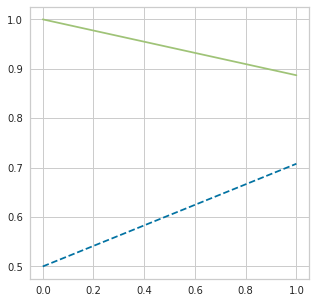

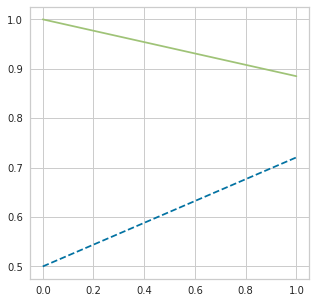

Train Log Loss:  8.276653506551131
Test Log Loss:  7.908905587774548


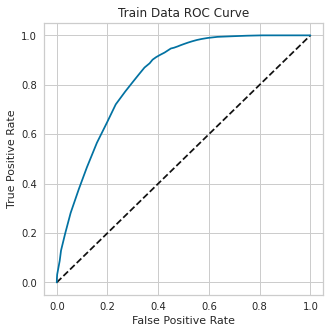

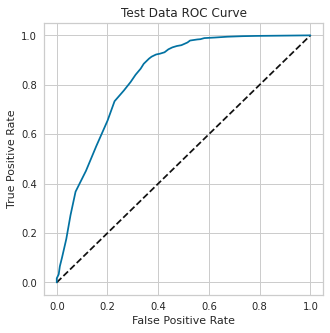




BernoulliNB Model
100%|██████████| 150/150 [00:06<00:00, 23.08trial/s, best loss: -0.6648201410654562]
best:
{'alpha': 1.5438588012232395}
Train Accuracy BernoulliNB 0.6648230088495575
Test Accuracy BernoulliNB 0.6808628318584071 

Accuracies Train BernoulliNB:
 [0.67265193 0.68370166 0.67773167 0.66804979 0.63762102 0.65698479
 0.65006916 0.65145228 0.65836791 0.69156293]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6648193148559944
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.015966436956323857 

Accuracies Test BernoulliNB:
 [0.66298343 0.70165746 0.69060773 0.67403315 0.62430939 0.6961326
 0.70718232 0.73480663 0.68888889 0.62777778]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6808379373848987
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.03287892607974218 



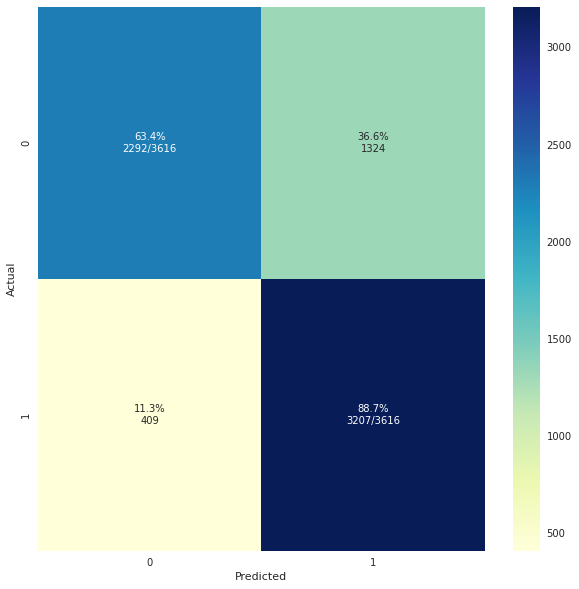

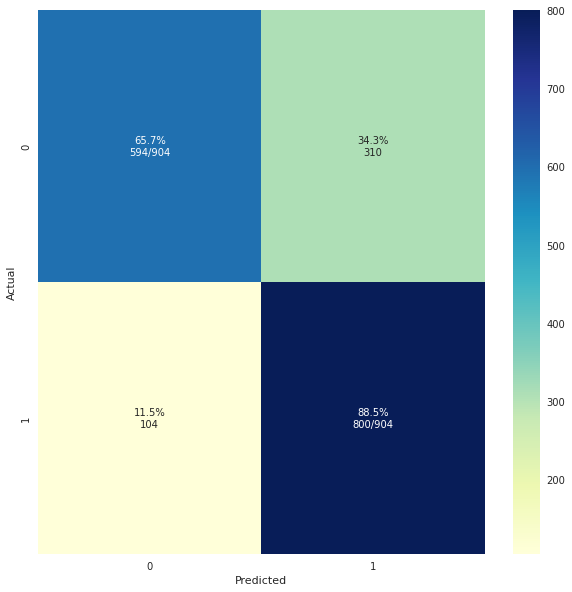

Train Accuracy Score After 10 K Fold CV 0.6648230088495575
Test Accuracy Score After 10 K Fold CV

 0.6808628318584071
Train Report:  
               precision    recall  f1-score   support

           0       0.74      0.50      0.60      3616
           1       0.62      0.82      0.71      3616

    accuracy                           0.66      7232
   macro avg       0.68      0.66      0.66      7232
weighted avg       0.68      0.66      0.66      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.77      0.52      0.62       904
           1       0.64      0.84      0.72       904

    accuracy                           0.68      1808
   macro avg       0.70      0.68      0.67      1808
weighted avg       0.70      0.68      0.67      1808



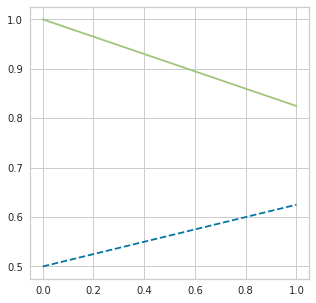

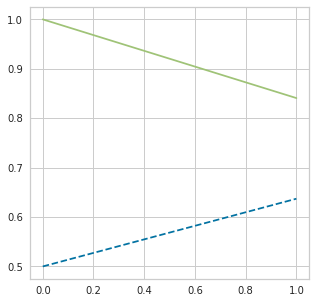

Train Log Loss:  11.57680105927317
Test Log Loss:  11.022798786255938


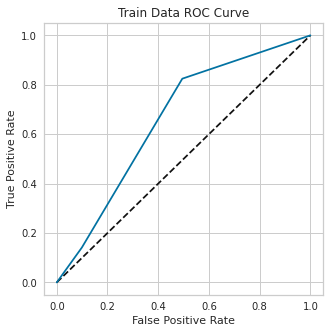

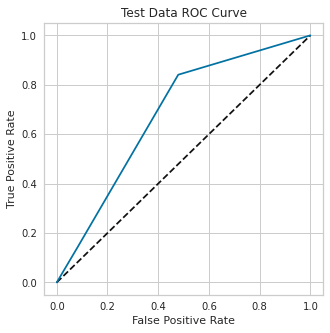




XGBoost Model
100%|██████████| 150/150 [18:38<00:00,  7.46s/trial, best loss: -0.7771017699115044]
The best hyperparameters are :  

{'colsample_bytree': 0.5958326365716146, 'gamma': 1.344456316419004, 'max_depth': 10, 'min_child_weight': 6.0, 'reg_alpha': 55.0, 'reg_lambda': 0.3844017729734205} 

Train Accuracy XGBoost 0.7697732300884956
Test Accuracy XGBoost 0.7748893805309734 

Accuracies Train XGBoost:
 [0.77486188 0.76381215 0.74965422 0.74688797 0.71507607 0.74688797
 0.74550484 0.7648686  0.76625173 0.78976487]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.7563570298709337
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.01931472346959894 

Accuracies Test XGBoost:
 [0.76243094 0.79558011 0.76243094 0.77348066 0.72375691 0.75138122
 0.79558011 0.78453039 0.81666667 0.73888889]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.7704726826273787
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.026972

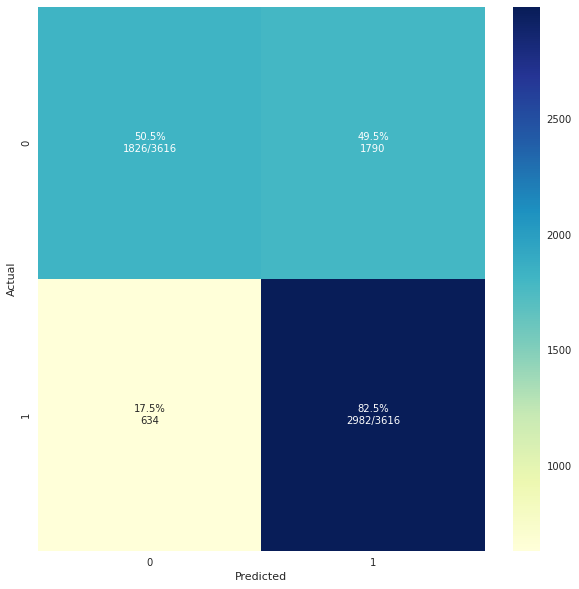

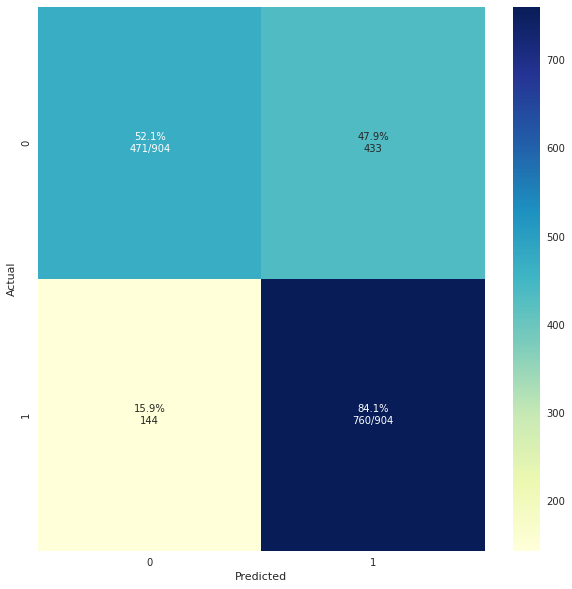

Train Accuracy Score After 10 K Fold CV 0.7697732300884956
Test Accuracy Score After 10 K Fold CV

 0.7748893805309734
Train Report:  
               precision    recall  f1-score   support

           0       0.85      0.65      0.74      3616
           1       0.72      0.89      0.79      3616

    accuracy                           0.77      7232
   macro avg       0.79      0.77      0.77      7232
weighted avg       0.79      0.77      0.77      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.85      0.67      0.75       904
           1       0.73      0.88      0.80       904

    accuracy                           0.77      1808
   macro avg       0.79      0.77      0.77      1808
weighted avg       0.79      0.77      0.77      1808



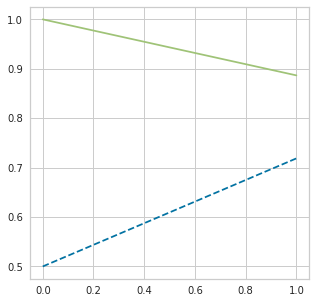

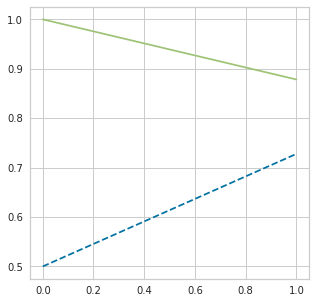

Train Log Loss:  7.951889683669964
Test Log Loss:  7.7751766997596325


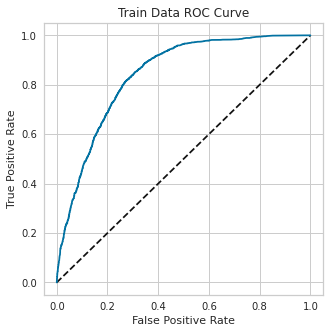

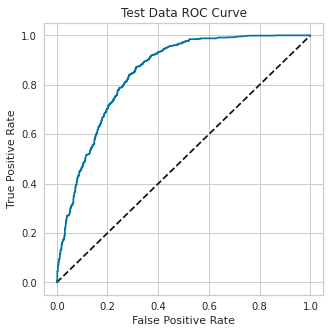

['bvp_binary_XGBoost.joblib']

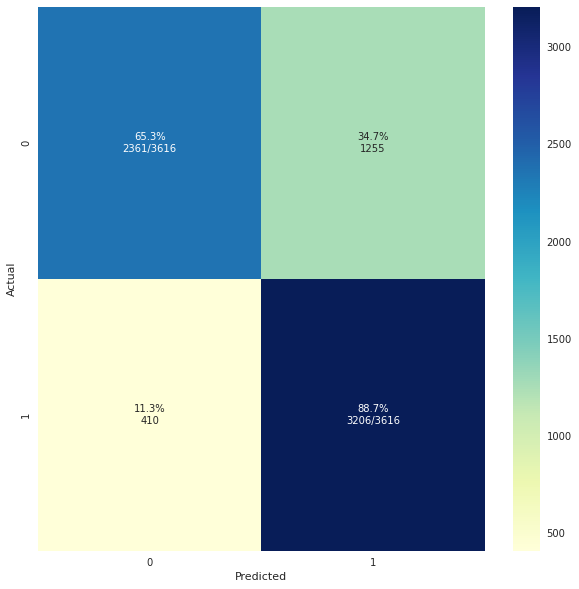

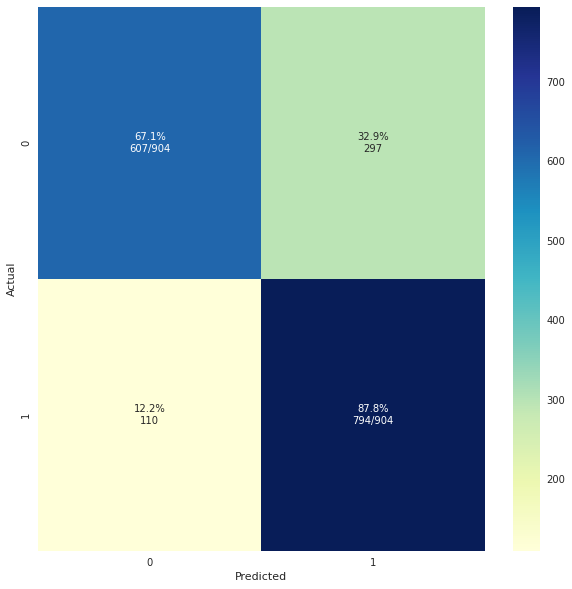

In [13]:
print("KNN Model : ")
xgboost_hyperpot_clf=knnhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_binary_knn.joblib') 
print("\n\n\nBernoulliNB Model")
xgboost_hyperpot_clf=nbhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_binary_nb.joblib') 
print("\n\n\nXGBoost Model")
xgboost_hyperpot_clf=xgboosthyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_binary_XGBoost.joblib') 



In [14]:
# print("\n\n\nLGBM Model")
# xgboost_hyperpot_clf=lgbmhyperopt(X_train, y_train,X_test,y_test)
# dump(xgboost_hyperpot_clf, 'bvp_binary_LGBMBoost.joblib')

<a id="subsection-two"></a>
## EDA Binary


In [15]:
ECGData=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-GSRBinary.csv')
temp=ECGData
temp =temp.drop(['id'],axis=1)
temp['stress'] = temp['stress'].replace([2],1)
corr_features = correlation(temp, 0.85)
temp=temp.drop(corr_features,axis=1)
from sklearn.model_selection import train_test_split
X = temp.drop(labels=['stress'],axis=1)
y = temp['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)




train shape: (7232, 11)
test shape: (1808, 11)


KNN Model : 
100%|██████████| 150/150 [01:05<00:00,  2.28trial/s, best loss: -0.7808356831189871]
best:
{'n_neighbors': 0}
Train Accuracy KNN 1.0
Test Accuracy KNN 0.8025442477876106 

Accuracies Train KNN:
 [0.75828729 0.79972376 0.78699862 0.79114799 0.77178423 0.79806362
 0.75518672 0.78699862 0.76901798 0.79114799]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7808356831189871
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.01526465941837358 

Accuracies Test KNN:
 [0.71270718 0.72375691 0.75690608 0.72375691 0.67955801 0.73480663
 0.73480663 0.70165746 0.7        0.72777778]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7195733578882749
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.020766853118424546 

Train Accuracy Score After 10 K Fold CV 1.0
Test Accuracy Score After 10 K Fold CV

 0.8025442477876106
Train Report:  
               precision    recall  f1-score   support

           0       1.00      1.00  

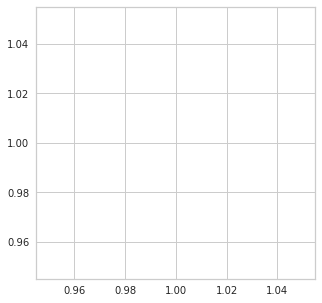

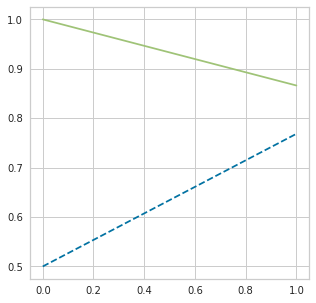

Train Log Loss:  9.992007221626413e-16
Test Log Loss:  6.81998444578354


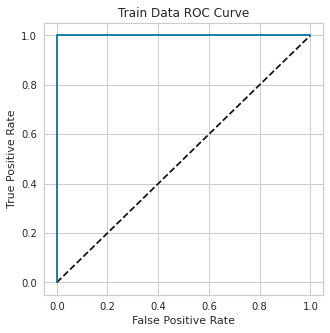

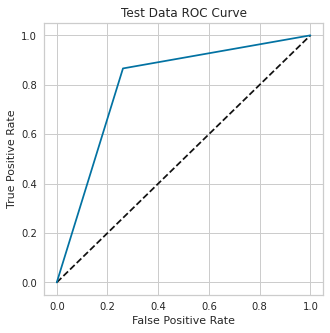




BernoulliNB Model
100%|██████████| 150/150 [00:07<00:00, 20.31trial/s, best loss: -0.6139356382882121]
best:
{'alpha': 0.7821309087639114}
Train Accuracy BernoulliNB 0.614629424778761
Test Accuracy BernoulliNB 0.6073008849557522 

Accuracies Train BernoulliNB:
 [0.60773481 0.63259669 0.61272476 0.65006916 0.61549101 0.58921162
 0.58782849 0.62517289 0.60304288 0.62240664]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6146278932929858
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.018168531930630397 

Accuracies Test BernoulliNB:
 [0.59116022 0.62430939 0.62430939 0.62983425 0.54696133 0.61325967
 0.62983425 0.60773481 0.68888889 0.61666667]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6172958870472682
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.03358047421045986 



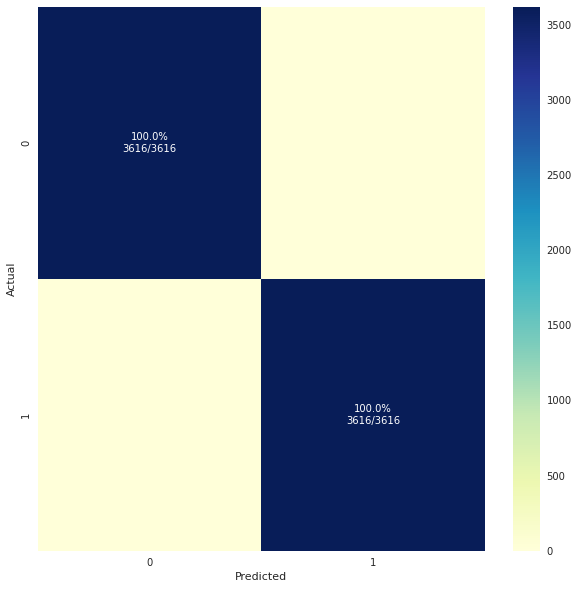

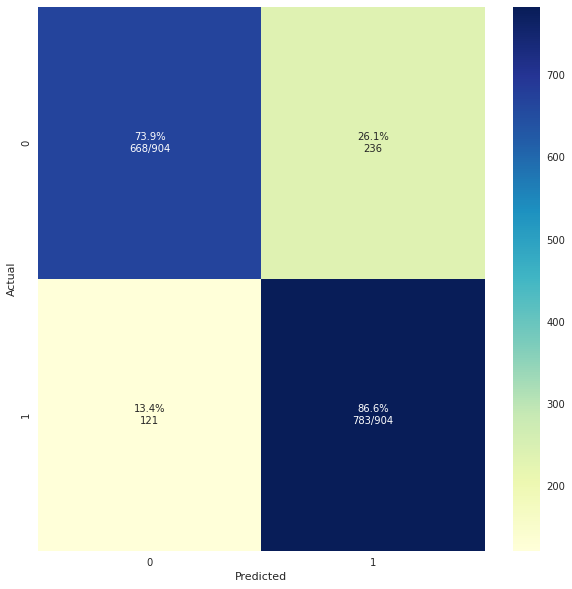

Train Accuracy Score After 10 K Fold CV 0.614629424778761
Test Accuracy Score After 10 K Fold CV

 0.6073008849557522
Train Report:  
               precision    recall  f1-score   support

           0       0.61      0.62      0.62      3616
           1       0.62      0.61      0.61      3616

    accuracy                           0.61      7232
   macro avg       0.61      0.61      0.61      7232
weighted avg       0.61      0.61      0.61      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.61      0.61      0.61       904
           1       0.61      0.60      0.61       904

    accuracy                           0.61      1808
   macro avg       0.61      0.61      0.61      1808
weighted avg       0.61      0.61      0.61      1808



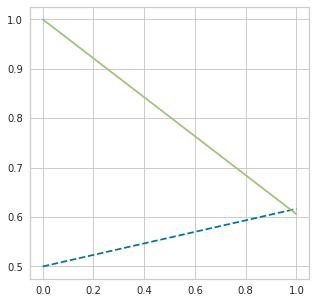

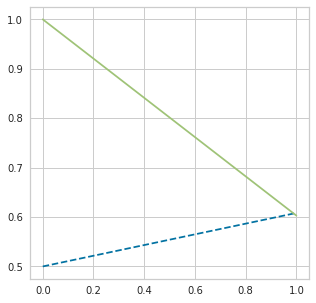

Train Log Loss:  13.310378714645463
Test Log Loss:  13.563502156573332


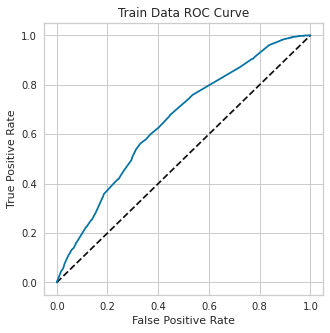

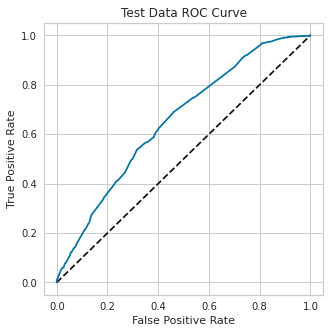




XGBoost Model
100%|██████████| 150/150 [19:06<00:00,  7.65s/trial, best loss: -0.7925884955752213]
The best hyperparameters are :  

{'colsample_bytree': 0.8525011088663794, 'gamma': 1.00051140716147, 'max_depth': 10, 'min_child_weight': 0.0, 'reg_alpha': 42.0, 'reg_lambda': 0.46765204547051487} 

Train Accuracy XGBoost 0.828816371681416
Test Accuracy XGBoost 0.8180309734513275 

Accuracies Train XGBoost:
 [0.79834254 0.83149171 0.77593361 0.81742739 0.78976487 0.78561549
 0.81604426 0.81466113 0.80497925 0.82572614]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.8059986397988735
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.01728643889634773 

Accuracies Test XGBoost:
 [0.73480663 0.6961326  0.74585635 0.77900552 0.70718232 0.79005525
 0.79005525 0.74033149 0.8        0.75555556]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.7538980969920196
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.0339199

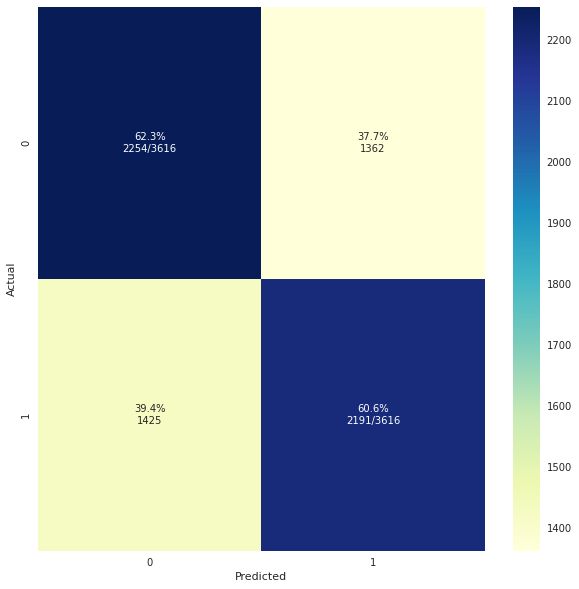

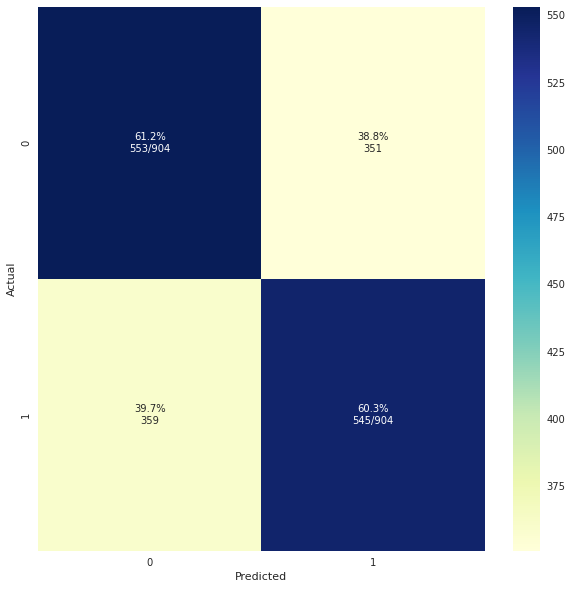

Train Accuracy Score After 10 K Fold CV 0.828816371681416
Test Accuracy Score After 10 K Fold CV

 0.8180309734513275
Train Report:  
               precision    recall  f1-score   support

           0       0.88      0.76      0.82      3616
           1       0.79      0.90      0.84      3616

    accuracy                           0.83      7232
   macro avg       0.84      0.83      0.83      7232
weighted avg       0.84      0.83      0.83      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.86      0.76      0.81       904
           1       0.79      0.87      0.83       904

    accuracy                           0.82      1808
   macro avg       0.82      0.82      0.82      1808
weighted avg       0.82      0.82      0.82      1808



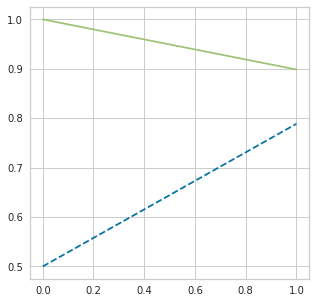

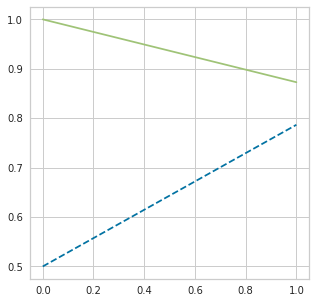

Train Log Loss:  5.91256936203832
Test Log Loss:  6.285082161380353


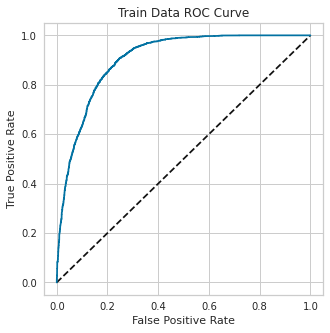

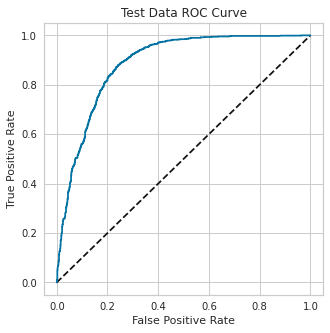

['bvp_binary_XGBoost.joblib']

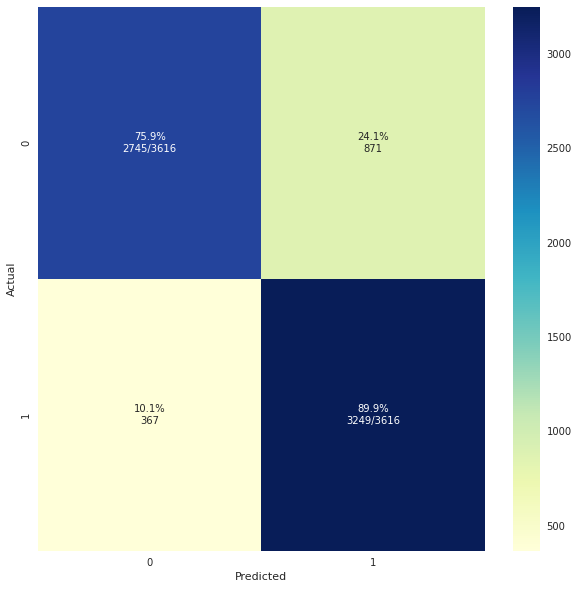

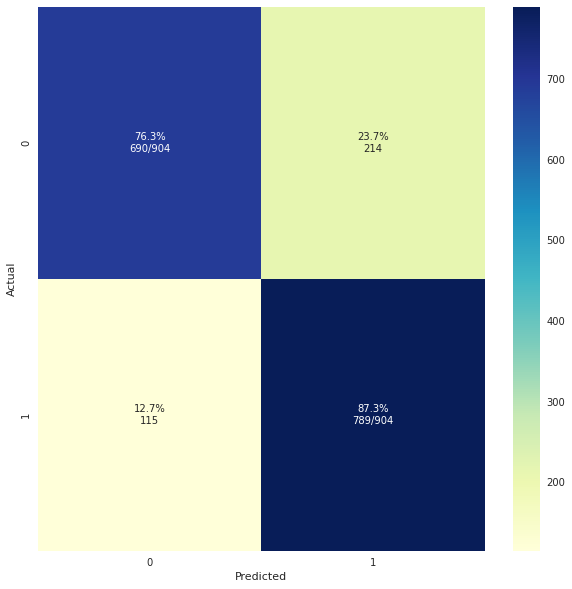

In [16]:
print("KNN Model : ")
xgboost_hyperpot_clf=knnhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_binary_knn.joblib') 
print("\n\n\nBernoulliNB Model")
xgboost_hyperpot_clf=nbhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_binary_nb.joblib') 
print("\n\n\nXGBoost Model")
xgboost_hyperpot_clf=xgboosthyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_binary_XGBoost.joblib') 



<a id="subsection-three"></a>
## Skin Temperature Binary


In [17]:
ECGData=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-SkinTemperatureBinary.csv')

In [18]:
temp=ECGData
temp =temp.drop(['id'],axis=1)
temp['stress'] = temp['stress'].replace([2],1)

ECGData=temp
corr_features = correlation(temp, 0.85)
temp=temp.drop(corr_features,axis=1)
from sklearn.model_selection import train_test_split
X = temp.drop(labels=['stress'],axis=1)
y = temp['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)


train shape: (7232, 2)
test shape: (1808, 2)


KNN Model : 
100%|██████████| 150/150 [00:33<00:00,  4.51trial/s, best loss: -0.725107555229515]
best:
{'n_neighbors': 6}
Train Accuracy KNN 0.7959070796460177
Test Accuracy KNN 0.7339601769911505 

Accuracies Train KNN:
 [0.74033149 0.72513812 0.69847856 0.73443983 0.72890733 0.68603043
 0.73305671 0.72475795 0.69709544 0.72890733]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7197143195555658
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.017722817188688775 

Accuracies Test KNN:
 [0.66850829 0.6961326  0.76243094 0.66850829 0.72375691 0.74033149
 0.68508287 0.76243094 0.67777778 0.71111111]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7096071209330879
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.03449857070500015 

Train Accuracy Score After 10 K Fold CV 0.7959070796460177
Test Accuracy Score After 10 K Fold CV

 0.7339601769911505
Train Report:  
               precision    recall  f1-score   support

      

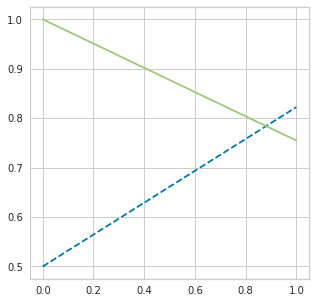

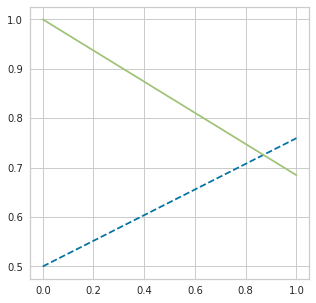

Train Log Loss:  7.049184861971039
Test Log Loss:  9.18877664106657


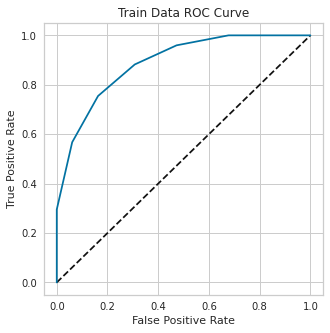

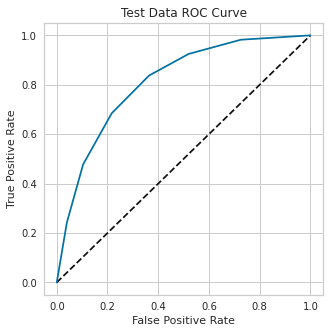




BernoulliNB Model
100%|██████████| 150/150 [00:05<00:00, 26.56trial/s, best loss: -0.4998617829993089]
best:
{'alpha': 1.4366150083847506}
Train Accuracy BernoulliNB 0.5
Test Accuracy BernoulliNB 0.5 

Accuracies Train BernoulliNB:
 [0.5        0.5        0.49930844 0.49930844 0.49930844 0.49930844
 0.49930844 0.49930844 0.49930844 0.49930844]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.49944674965421854
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.00027662517289073213 

Accuracies Test BernoulliNB:
 [0.49723757 0.49723757 0.49723757 0.49723757 0.49723757 0.49723757
 0.49723757 0.49723757 0.5        0.5       ]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.49779005524861886
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.0011049723756906048 



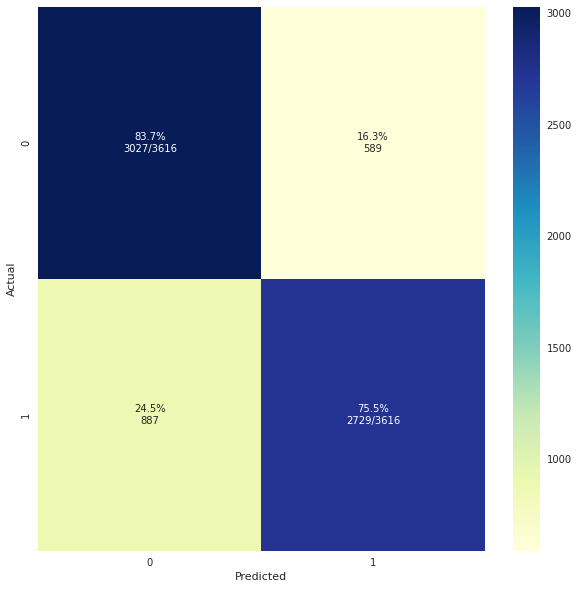

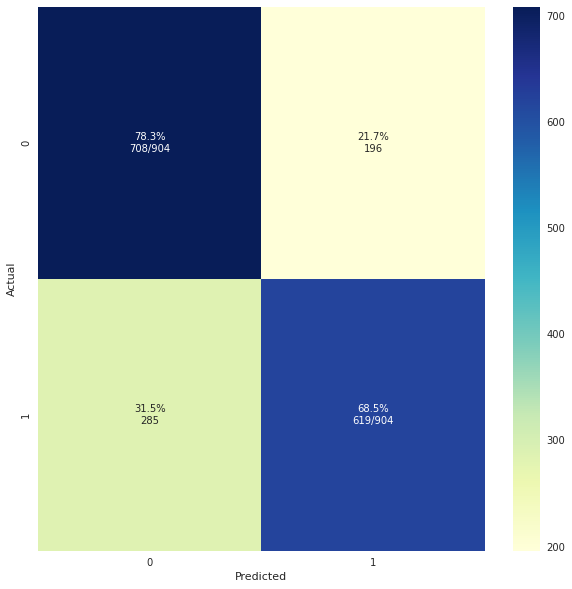

Train Accuracy Score After 10 K Fold CV 0.5
Test Accuracy Score After 10 K Fold CV

 0.5
Train Report:  
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      3616
           1       0.00      0.00      0.00      3616

    accuracy                           0.50      7232
   macro avg       0.25      0.50      0.33      7232
weighted avg       0.25      0.50      0.33      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       904
           1       0.00      0.00      0.00       904

    accuracy                           0.50      1808
   macro avg       0.25      0.50      0.33      1808
weighted avg       0.25      0.50      0.33      1808



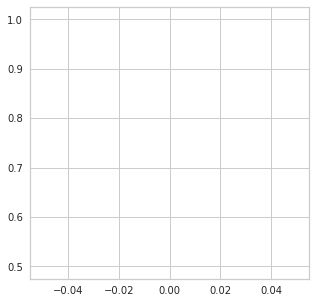

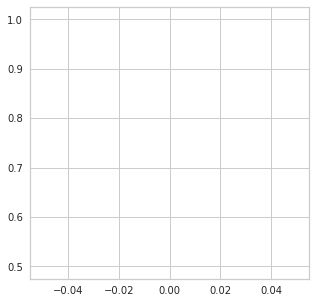

Train Log Loss:  17.269388197455342
Test Log Loss:  17.269388197455342


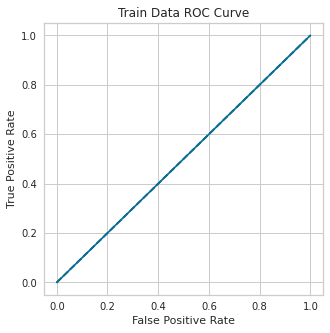

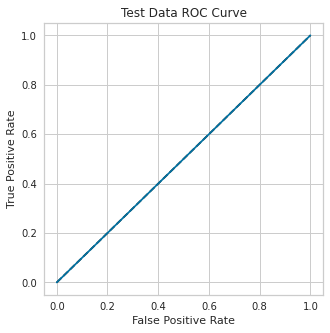




XGBoost Model
100%|██████████| 150/150 [18:54<00:00,  7.57s/trial, best loss: -0.7140486725663717]
The best hyperparameters are :  

{'colsample_bytree': 0.6041798515786918, 'gamma': 2.8392004961837065, 'max_depth': 8, 'min_child_weight': 5.0, 'reg_alpha': 45.0, 'reg_lambda': 0.8316835878944875} 

Train Accuracy XGBoost 0.7034015486725663
Test Accuracy XGBoost 0.7140486725663717 

Accuracies Train XGBoost:
 [0.70994475 0.70165746 0.66390041 0.70677732 0.71784232 0.66666667
 0.66666667 0.68326418 0.68603043 0.7275242 ]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.6930274409114876
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.02176690327271998 

Accuracies Test XGBoost:
 [0.61325967 0.63535912 0.54143646 0.59668508 0.55801105 0.55248619
 0.56353591 0.49723757 0.53888889 0.5       ]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.5596899938612646
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.042734

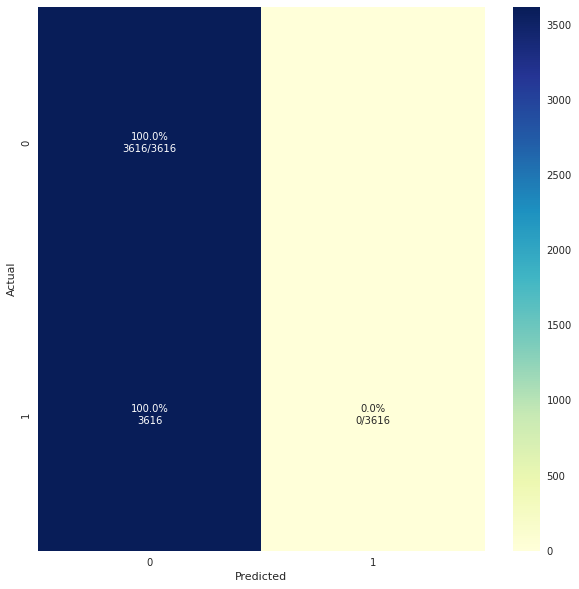

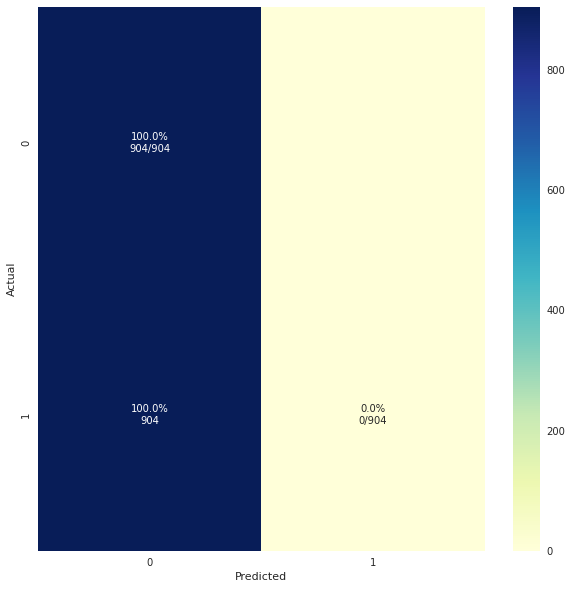

Train Accuracy Score After 10 K Fold CV 0.7034015486725663
Test Accuracy Score After 10 K Fold CV

 0.7140486725663717
Train Report:  
               precision    recall  f1-score   support

           0       0.72      0.67      0.69      3616
           1       0.69      0.74      0.71      3616

    accuracy                           0.70      7232
   macro avg       0.70      0.70      0.70      7232
weighted avg       0.70      0.70      0.70      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.74      0.67      0.70       904
           1       0.70      0.76      0.73       904

    accuracy                           0.71      1808
   macro avg       0.72      0.71      0.71      1808
weighted avg       0.72      0.71      0.71      1808



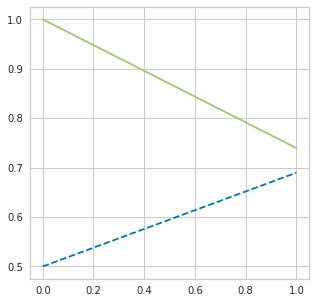

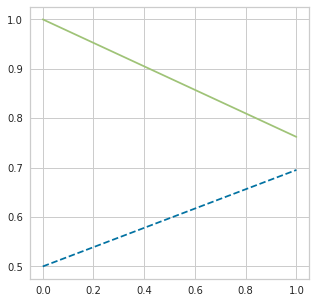

Train Log Loss:  10.244280597731187
Test Log Loss:  9.876542519133153


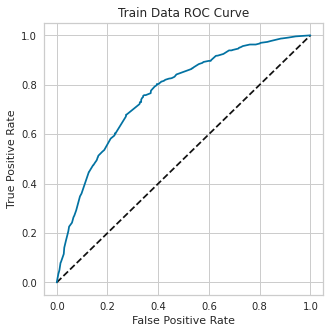

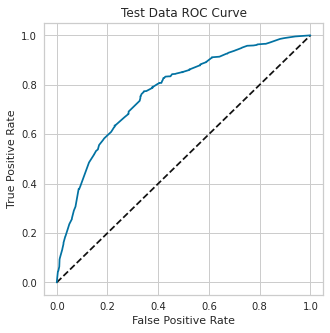

['st_binary_XGBoost.joblib']

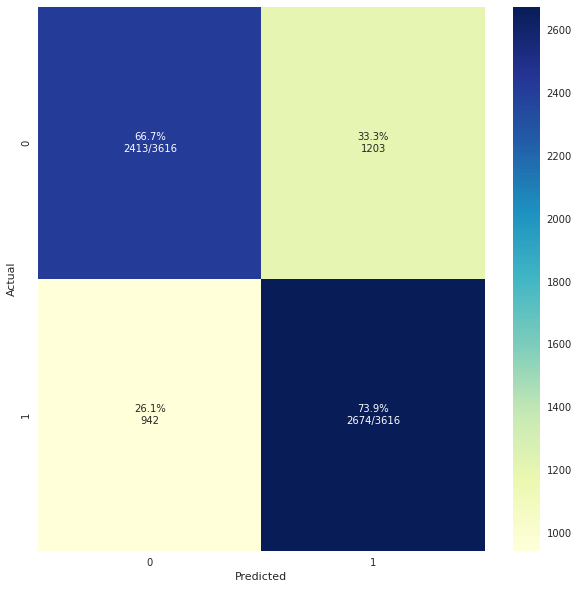

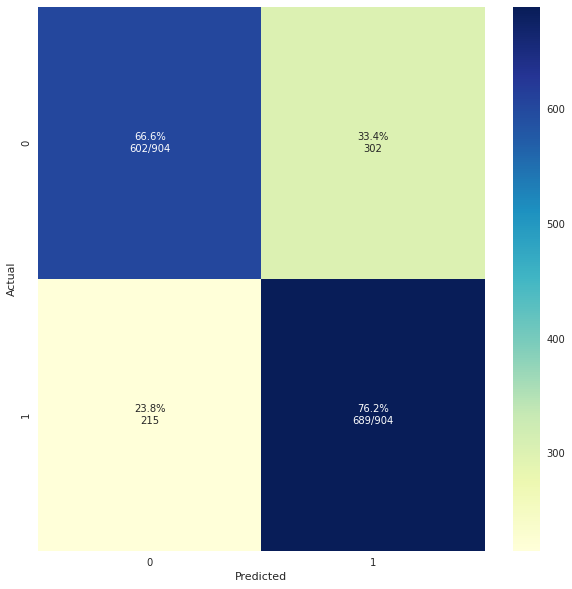

In [19]:
print("KNN Model : ")
xgboost_hyperpot_clf=knnhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'st_binary_knn.joblib') 
print("\n\n\nBernoulliNB Model")
xgboost_hyperpot_clf=nbhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'st_binary_nb.joblib') 
print("\n\n\nXGBoost Model")
xgboost_hyperpot_clf=xgboosthyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'st_binary_XGBoost.joblib') 



<a id="subsection-four"></a>
## BVP + GSR Binary Class


In [20]:
ECGData=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-BVPBinary.csv')
otherdata=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-GSRBinary.csv')
otherdata['stress'] = otherdata['stress'].replace([2],1)
temp=ECGData
temp =temp.drop(['csi','cvi','Modified_csi','sd2','ratio_sd2_sd1'],axis=1)
temp['stress'] = temp['stress'].replace([2],1)

ECGData=temp

temp=pd.merge(ECGData,otherdata,on=['id','stress'])

ECGData=temp

corr_features = correlation(temp, 0.85)
temp=temp.drop(corr_features,axis=1)
from sklearn.model_selection import train_test_split
X = temp.drop(labels=['stress'],axis=1)
y = temp['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)


train shape: (7232, 22)
test shape: (1808, 22)


KNN Model : 
100%|██████████| 150/150 [02:08<00:00,  1.16trial/s, best loss: -0.7375541596937255]
best:
{'n_neighbors': 40}
Train Accuracy KNN 0.7437776548672567
Test Accuracy KNN 0.7654867256637168 

Accuracies Train KNN:
 [0.73618785 0.74309392 0.73305671 0.73582296 0.69986169 0.74135546
 0.70816044 0.73582296 0.73858921 0.77178423]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7343735433239342
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.018519033311031004 

Accuracies Test KNN:
 [0.71823204 0.74033149 0.75138122 0.68508287 0.64088398 0.73480663
 0.74033149 0.75138122 0.73333333 0.65      ]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7145764272559852
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.03909071438905066 

Train Accuracy Score After 10 K Fold CV 0.7437776548672567
Test Accuracy Score After 10 K Fold CV

 0.7654867256637168
Train Report:  
               precision    recall  f1-score   support

    

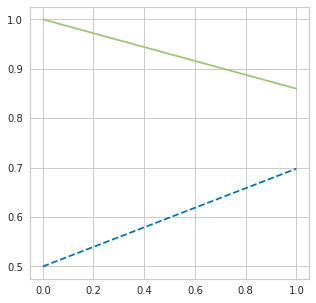

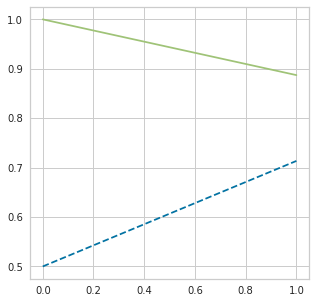

Train Log Loss:  8.849755104799577
Test Log Loss:  8.099943950118723


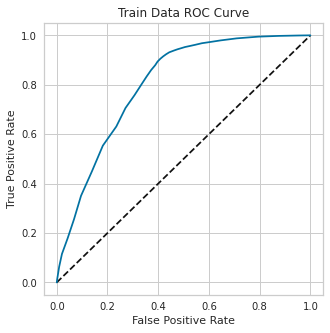

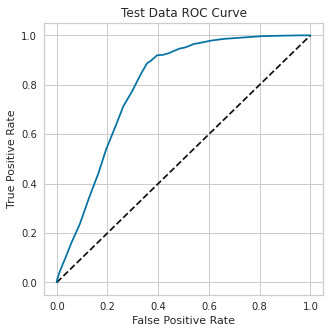




BernoulliNB Model
100%|██████████| 150/150 [00:09<00:00, 16.18trial/s, best loss: -0.6724249436760943]
best:
{'alpha': 1.7829441313072103}
Train Accuracy BernoulliNB 0.6722898230088495
Test Accuracy BernoulliNB 0.6963495575221239 

Accuracies Train BernoulliNB:
 [0.67403315 0.70027624 0.68049793 0.68049793 0.65006916 0.65836791
 0.65698479 0.66666667 0.66528354 0.69156293]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6724240235971971
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.015148686808344618 

Accuracies Test BernoulliNB:
 [0.65745856 0.71823204 0.70718232 0.70718232 0.62983425 0.70165746
 0.72375691 0.70718232 0.71666667 0.66111111]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6930263965623082
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.030151484353937216 



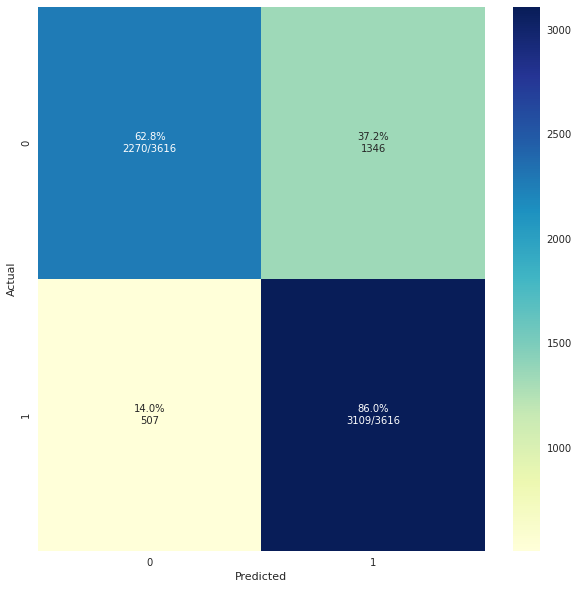

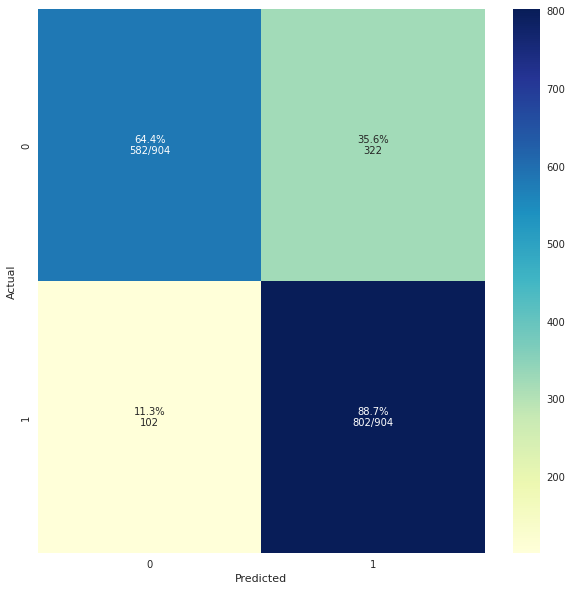

Train Accuracy Score After 10 K Fold CV 0.6722898230088495
Test Accuracy Score After 10 K Fold CV

 0.6963495575221239
Train Report:  
               precision    recall  f1-score   support

           0       0.73      0.55      0.63      3616
           1       0.64      0.80      0.71      3616

    accuracy                           0.67      7232
   macro avg       0.68      0.67      0.67      7232
weighted avg       0.68      0.67      0.67      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.76      0.58      0.66       904
           1       0.66      0.82      0.73       904

    accuracy                           0.70      1808
   macro avg       0.71      0.70      0.69      1808
weighted avg       0.71      0.70      0.69      1808



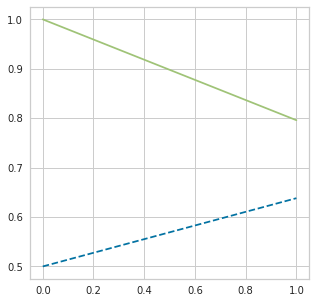

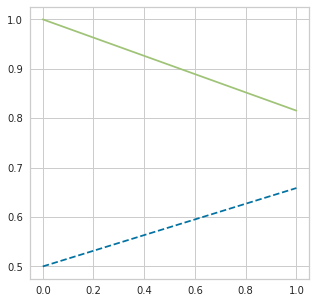

Train Log Loss:  11.318888965562001
Test Log Loss:  10.487883676451492


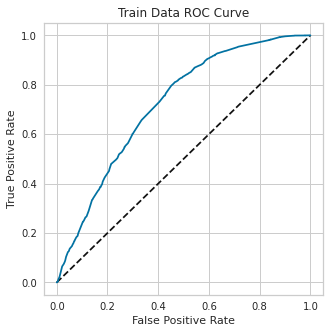

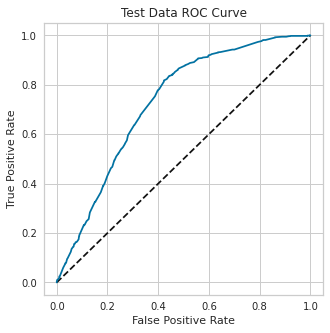




XGBoost Model
100%|██████████| 150/150 [18:52<00:00,  7.55s/trial, best loss: -0.8412610619469026]
The best hyperparameters are :  

{'colsample_bytree': 0.9180868850981804, 'gamma': 4.2807309144774095, 'max_depth': 15, 'min_child_weight': 2.0, 'reg_alpha': 45.0, 'reg_lambda': 0.3064255915754621} 

Train Accuracy XGBoost 0.8555033185840708
Test Accuracy XGBoost 0.8517699115044248 

Accuracies Train XGBoost:
 [0.8480663  0.87016575 0.84094053 0.83817427 0.81051176 0.82849239
 0.82987552 0.8395574  0.83264177 0.87275242]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.8411178102290181
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.017883812204906202 

Accuracies Test XGBoost:
 [0.78453039 0.79558011 0.77348066 0.7679558  0.77348066 0.82872928
 0.82872928 0.78453039 0.78888889 0.77222222]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.7898127685696746
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.0210

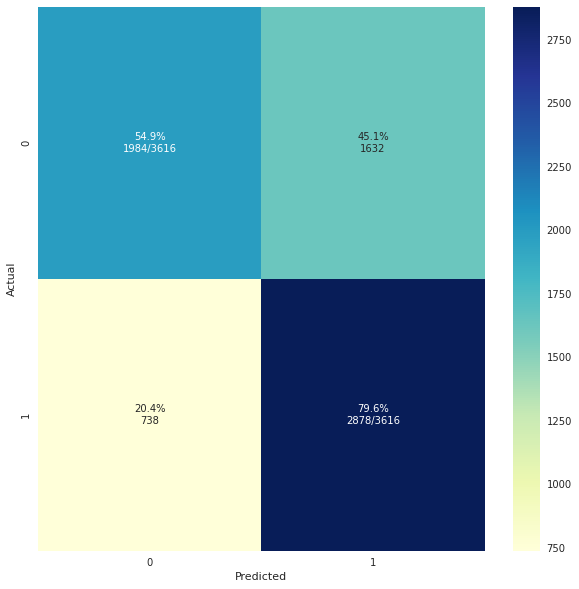

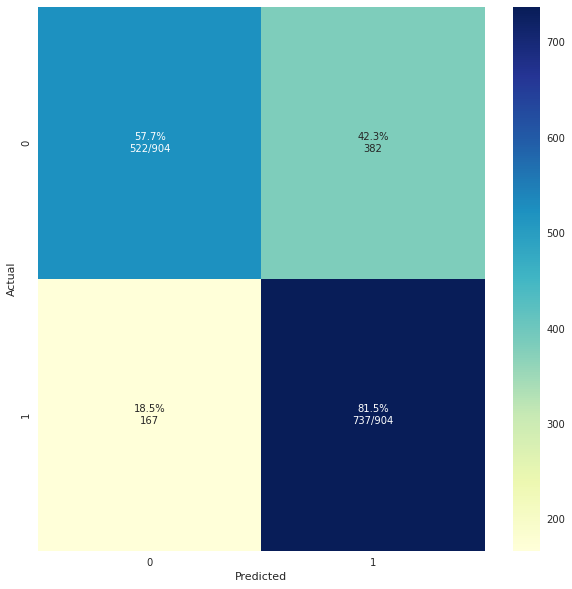

Train Accuracy Score After 10 K Fold CV 0.8555033185840708
Test Accuracy Score After 10 K Fold CV

 0.8517699115044248
Train Report:  
               precision    recall  f1-score   support

           0       0.92      0.78      0.84      3616
           1       0.81      0.93      0.87      3616

    accuracy                           0.86      7232
   macro avg       0.86      0.86      0.85      7232
weighted avg       0.86      0.86      0.85      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.91      0.78      0.84       904
           1       0.81      0.92      0.86       904

    accuracy                           0.85      1808
   macro avg       0.86      0.85      0.85      1808
weighted avg       0.86      0.85      0.85      1808



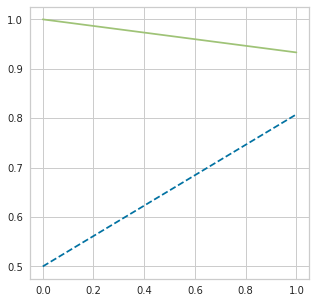

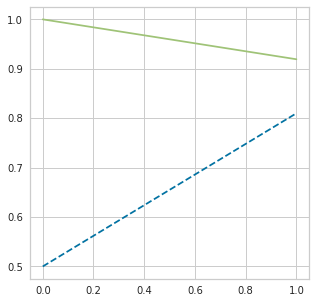

Train Log Loss:  4.990827351966
Test Log Loss:  5.119772121313581


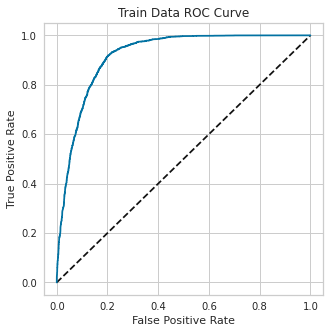

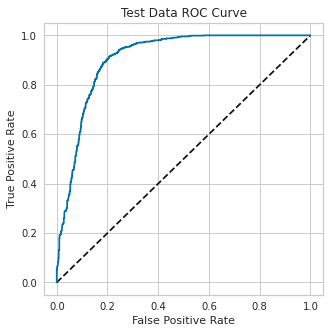

['bvp_gsr_binary_XGBoost.joblib']

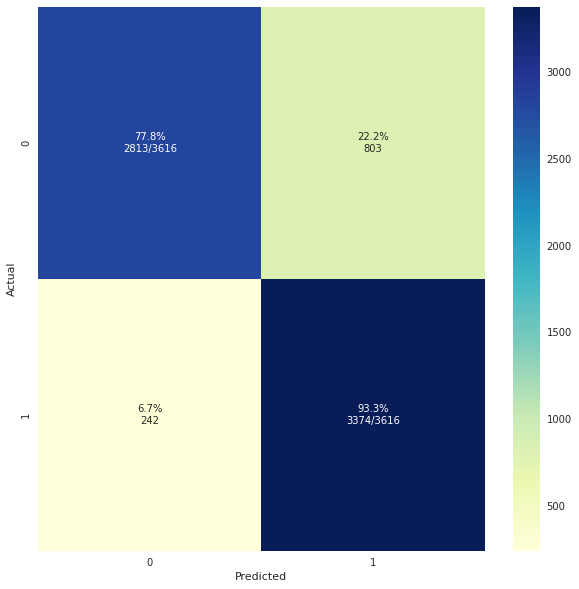

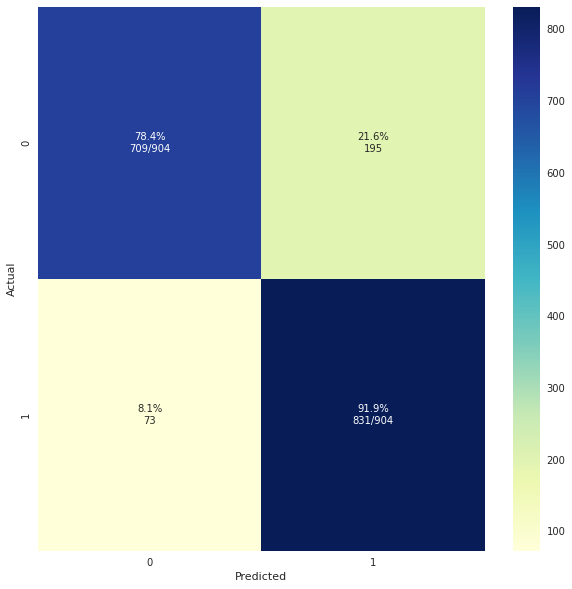

In [21]:
print("KNN Model : ")
xgboost_hyperpot_clf=knnhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_gsr_binary_knn.joblib') 
print("\n\n\nBernoulliNB Model")
xgboost_hyperpot_clf=nbhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_gsr_binary_nb.joblib') 
print("\n\n\nXGBoost Model")
xgboost_hyperpot_clf=xgboosthyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_gsr_binary_XGBoost.joblib') 



<a id="subsection-five"></a>
## BVP + ST Binary Class


In [22]:
ECGData=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-BVPBinary.csv')
otherdata=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-SkinTemperatureBinary.csv')
otherdata['stress'] = otherdata['stress'].replace([2],1)
temp=ECGData
temp =temp.drop(['csi','cvi','Modified_csi','sd2','ratio_sd2_sd1'],axis=1)
temp['stress'] = temp['stress'].replace([2],1)

ECGData=temp
temp=pd.merge(ECGData,otherdata,on=['id','stress'])

temp =temp.drop(['id'],axis=1)

ECGData=temp

corr_features = correlation(temp, 0.85)
temp=temp.drop(corr_features,axis=1)
from sklearn.model_selection import train_test_split
X = temp.drop(labels=['stress'],axis=1)
y = temp['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)


train shape: (7232, 12)
test shape: (1808, 12)


KNN Model : 
100%|██████████| 150/150 [00:42<00:00,  3.56trial/s, best loss: -0.7535915422999626]
best:
{'n_neighbors': 4}
Train Accuracy KNN 0.8441648230088495
Test Accuracy KNN 0.7527654867256637 

Accuracies Train KNN:
 [0.75966851 0.72651934 0.73858921 0.71507607 0.73029046 0.7275242
 0.71230982 0.71784232 0.7164592  0.74550484]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7289783972551447
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.014384421305119813 

Accuracies Test KNN:
 [0.67955801 0.6961326  0.73480663 0.74033149 0.64640884 0.70165746
 0.77900552 0.70165746 0.70555556 0.72222222]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7107335788827501
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.0342971374561344 

Train Accuracy Score After 10 K Fold CV 0.8441648230088495
Test Accuracy Score After 10 K Fold CV

 0.7527654867256637
Train Report:  
               precision    recall  f1-score   support

       

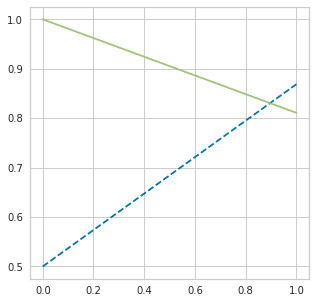

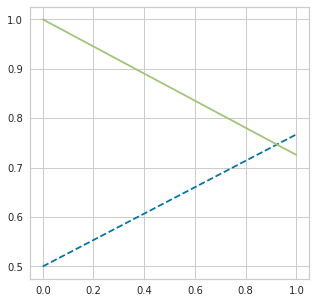

Train Log Loss:  5.382405312323827
Test Log Loss:  8.539265579874826


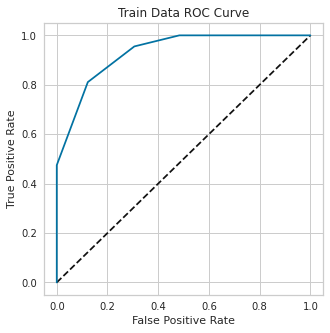

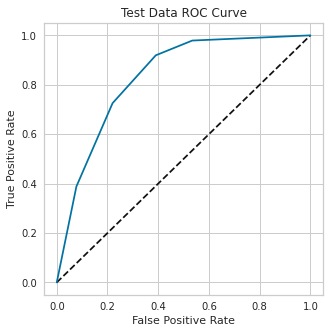




BernoulliNB Model
100%|██████████| 150/150 [00:06<00:00, 21.91trial/s, best loss: -0.6648201410654562]
best:
{'alpha': 1.8924103921098252}
Train Accuracy BernoulliNB 0.6648230088495575
Test Accuracy BernoulliNB 0.6808628318584071 

Accuracies Train BernoulliNB:
 [0.67265193 0.68370166 0.67773167 0.66804979 0.63762102 0.65698479
 0.65006916 0.65145228 0.65836791 0.69156293]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6648193148559944
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.015966436956323857 

Accuracies Test BernoulliNB:
 [0.66298343 0.70165746 0.69060773 0.67403315 0.62430939 0.6961326
 0.70718232 0.73480663 0.68888889 0.62777778]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6808379373848987
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.03287892607974218 



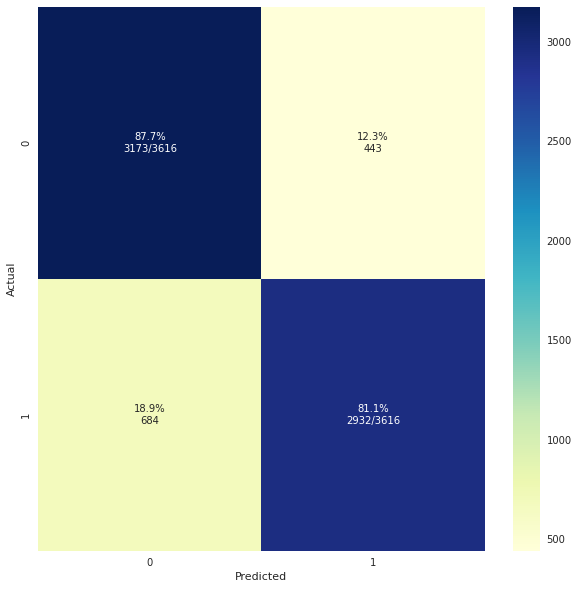

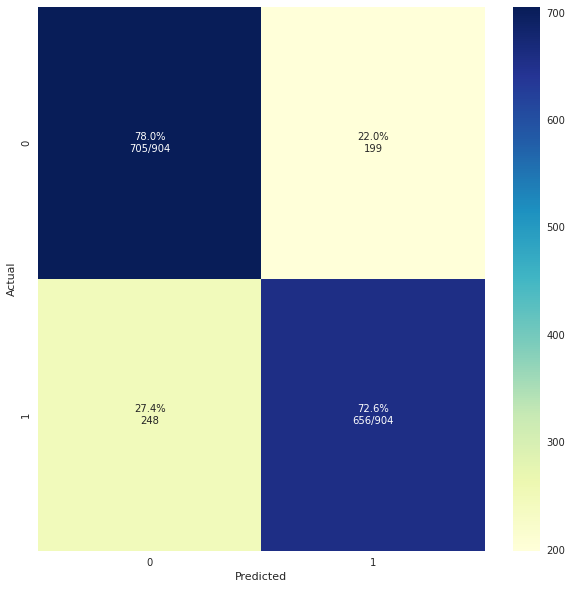

Train Accuracy Score After 10 K Fold CV 0.6648230088495575
Test Accuracy Score After 10 K Fold CV

 0.6808628318584071
Train Report:  
               precision    recall  f1-score   support

           0       0.74      0.50      0.60      3616
           1       0.62      0.82      0.71      3616

    accuracy                           0.66      7232
   macro avg       0.68      0.66      0.66      7232
weighted avg       0.68      0.66      0.66      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.77      0.52      0.62       904
           1       0.64      0.84      0.72       904

    accuracy                           0.68      1808
   macro avg       0.70      0.68      0.67      1808
weighted avg       0.70      0.68      0.67      1808



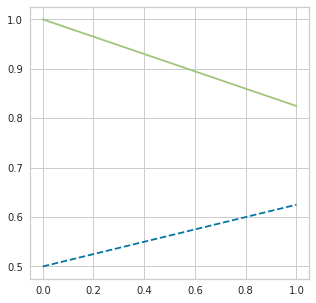

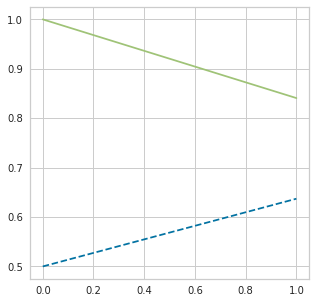

Train Log Loss:  11.57680105927317
Test Log Loss:  11.022798786255938


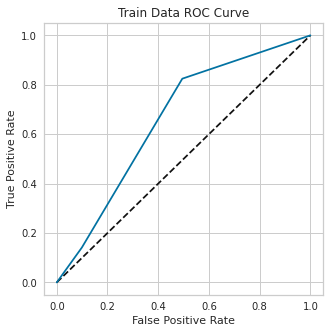

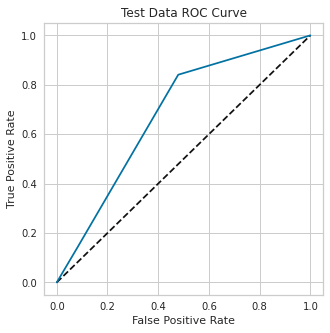




XGBoost Model
100%|██████████| 150/150 [18:10<00:00,  7.27s/trial, best loss: -0.8324115044247787]
The best hyperparameters are :  

{'colsample_bytree': 0.7979564838648903, 'gamma': 1.0447801299183836, 'max_depth': 12, 'min_child_weight': 3.0, 'reg_alpha': 41.0, 'reg_lambda': 0.9872514593022954} 

Train Accuracy XGBoost 0.8657356194690266
Test Accuracy XGBoost 0.8501106194690266 

Accuracies Train XGBoost:
 [0.85497238 0.83977901 0.82157676 0.83817427 0.81189488 0.8395574
 0.81604426 0.8340249  0.84923928 0.85892116]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.8364184299611044
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.0151054324574582 

Accuracies Test XGBoost:
 [0.74585635 0.80110497 0.79005525 0.80110497 0.74585635 0.77348066
 0.79558011 0.80110497 0.81666667 0.76666667]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.7837476979742173
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.0233151

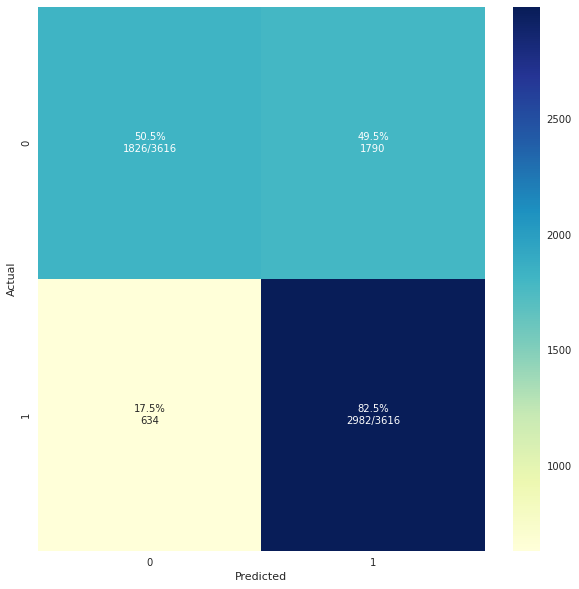

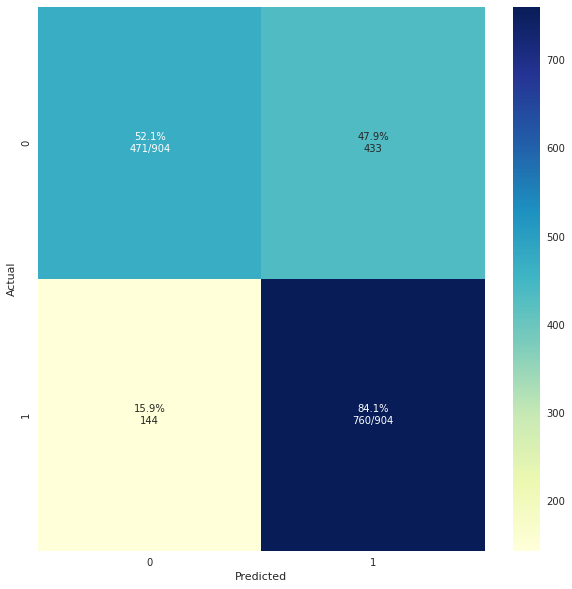

Train Accuracy Score After 10 K Fold CV 0.8657356194690266
Test Accuracy Score After 10 K Fold CV

 0.8501106194690266
Train Report:  
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      3616
           1       0.84      0.90      0.87      3616

    accuracy                           0.87      7232
   macro avg       0.87      0.87      0.87      7232
weighted avg       0.87      0.87      0.87      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.89      0.80      0.84       904
           1       0.82      0.90      0.86       904

    accuracy                           0.85      1808
   macro avg       0.85      0.85      0.85      1808
weighted avg       0.85      0.85      0.85      1808



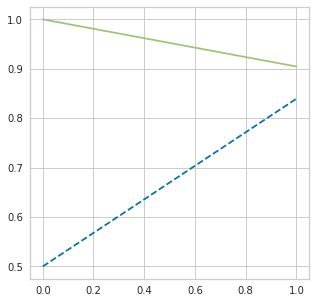

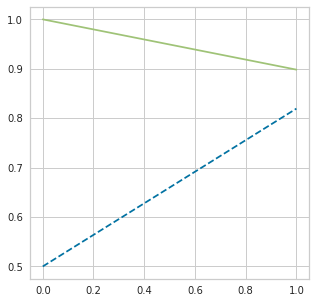

Train Log Loss:  4.637396629901767
Test Log Loss:  5.177074961814602


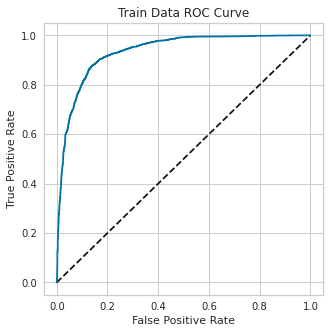

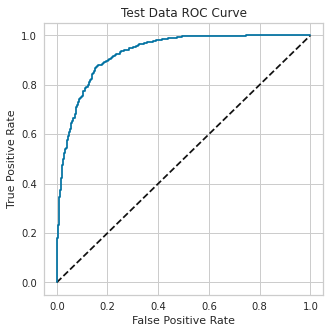

['bvp_st_binary_XGBoost.joblib']

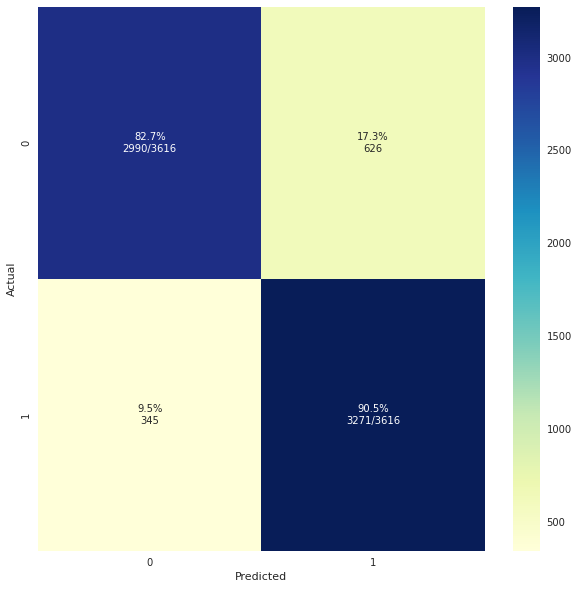

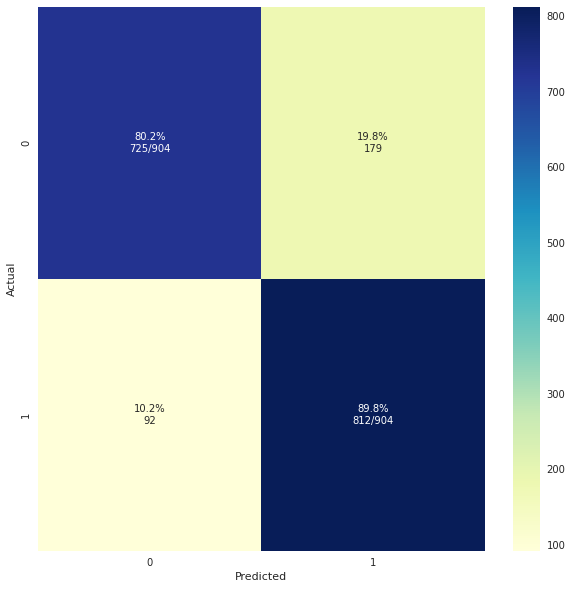

In [23]:
print("KNN Model : ")
xgboost_hyperpot_clf=knnhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_st_binary_knn.joblib') 
print("\n\n\nBernoulliNB Model")
xgboost_hyperpot_clf=nbhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_st_binary_nb.joblib') 
print("\n\n\nXGBoost Model")
xgboost_hyperpot_clf=xgboosthyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_st_binary_XGBoost.joblib') 



<a id="subsection-six"></a>
## GSR + ST Binary Class


In [24]:
otherdata=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-SkinTemperatureBinary.csv')
ECGData=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-GSRBinary.csv')
temp=ECGData


ECGData=temp
temp=pd.merge(ECGData,otherdata,on=['id','stress'])
temp =temp.drop(['id'],axis=1)
temp['stress'] = temp['stress'].replace([2],1)

ECGData=temp
corr_features = correlation(temp, 0.85)
temp=temp.drop(corr_features,axis=1)
from sklearn.model_selection import train_test_split
X = temp.drop(labels=['stress'],axis=1)
y = temp['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)




train shape: (7232, 13)
test shape: (1808, 13)


KNN Model : 
100%|██████████| 150/150 [01:11<00:00,  2.09trial/s, best loss: -0.8514937377257132]
best:
{'n_neighbors': 0}
Train Accuracy KNN 1.0
Test Accuracy KNN 0.8722345132743363 

Accuracies Train KNN:
 [0.83701657 0.86325967 0.84785615 0.86445367 0.82572614 0.86721992
 0.85477178 0.86445367 0.83125864 0.85892116]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.8514937377257132
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.014435476435016822 

Accuracies Test KNN:
 [0.80662983 0.80662983 0.80662983 0.79558011 0.74585635 0.79558011
 0.7679558  0.79005525 0.75       0.80555556]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7870472682627379
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.02254180508611799 

Train Accuracy Score After 10 K Fold CV 1.0
Test Accuracy Score After 10 K Fold CV

 0.8722345132743363
Train Report:  
               precision    recall  f1-score   support

           0       1.00      1.00  

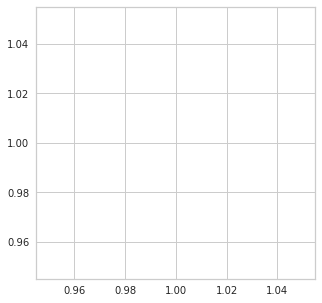

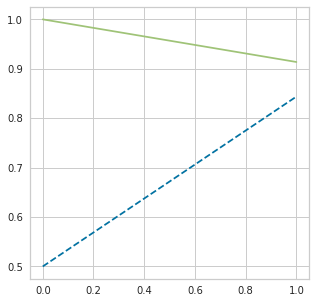

Train Log Loss:  9.992007221626413e-16
Test Log Loss:  4.4129312420526485


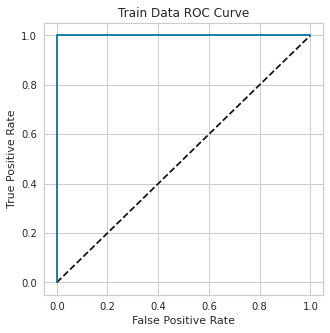

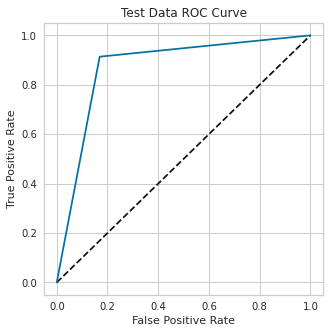




BernoulliNB Model
100%|██████████| 150/150 [00:06<00:00, 21.79trial/s, best loss: -0.6139356382882121]
best:
{'alpha': 1.288913300244281}
Train Accuracy BernoulliNB 0.614629424778761
Test Accuracy BernoulliNB 0.6073008849557522 

Accuracies Train BernoulliNB:
 [0.60773481 0.63259669 0.61272476 0.65006916 0.61549101 0.58921162
 0.58782849 0.62517289 0.60304288 0.62240664]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6146278932929858
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.018168531930630397 

Accuracies Test BernoulliNB:
 [0.59116022 0.62430939 0.62430939 0.62983425 0.54696133 0.61325967
 0.62983425 0.60773481 0.68888889 0.61666667]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6172958870472682
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.03358047421045986 



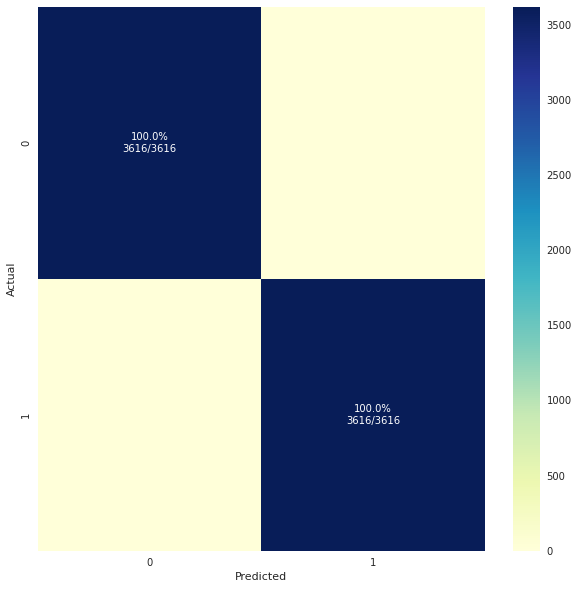

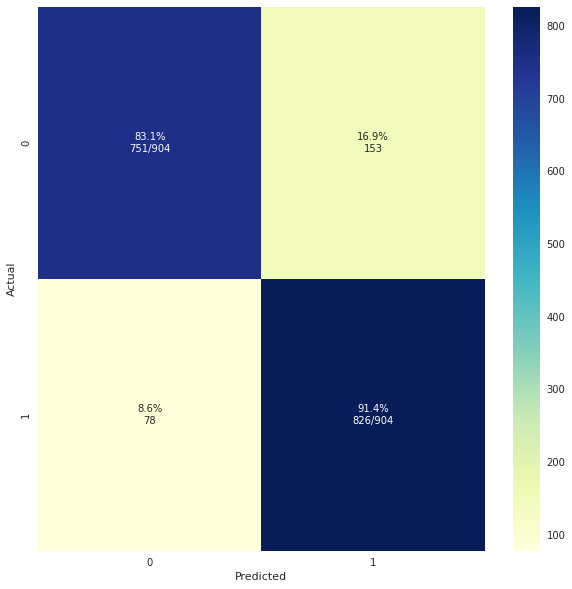

Train Accuracy Score After 10 K Fold CV 0.614629424778761
Test Accuracy Score After 10 K Fold CV

 0.6073008849557522
Train Report:  
               precision    recall  f1-score   support

           0       0.61      0.62      0.62      3616
           1       0.62      0.61      0.61      3616

    accuracy                           0.61      7232
   macro avg       0.61      0.61      0.61      7232
weighted avg       0.61      0.61      0.61      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.61      0.61      0.61       904
           1       0.61      0.60      0.61       904

    accuracy                           0.61      1808
   macro avg       0.61      0.61      0.61      1808
weighted avg       0.61      0.61      0.61      1808



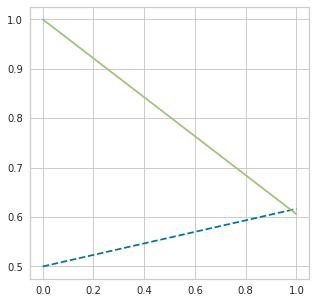

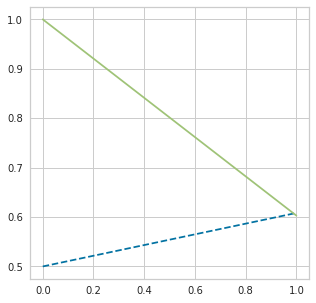

Train Log Loss:  13.310378714645463
Test Log Loss:  13.563502156573332


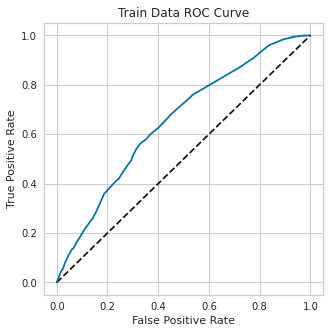

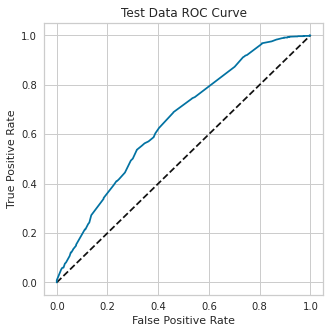




XGBoost Model
100%|██████████| 150/150 [19:14<00:00,  7.70s/trial, best loss: -0.8611725663716814]
The best hyperparameters are :  

{'colsample_bytree': 0.9076895136329187, 'gamma': 1.1590145748000538, 'max_depth': 8, 'min_child_weight': 8.0, 'reg_alpha': 42.0, 'reg_lambda': 0.8515497400835494} 

Train Accuracy XGBoost 0.9227046460176991
Test Accuracy XGBoost 0.9214601769911505 

Accuracies Train XGBoost:
 [0.90883978 0.91022099 0.88658368 0.9142462  0.87828492 0.88934993
 0.90456432 0.89488243 0.87828492 0.92392808]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.8989185254808463
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.014933032854408468 

Accuracies Test XGBoost:
 [0.71270718 0.7679558  0.77900552 0.80662983 0.76243094 0.83977901
 0.83977901 0.75690608 0.80555556 0.75555556]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.7826304481276857
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.03814

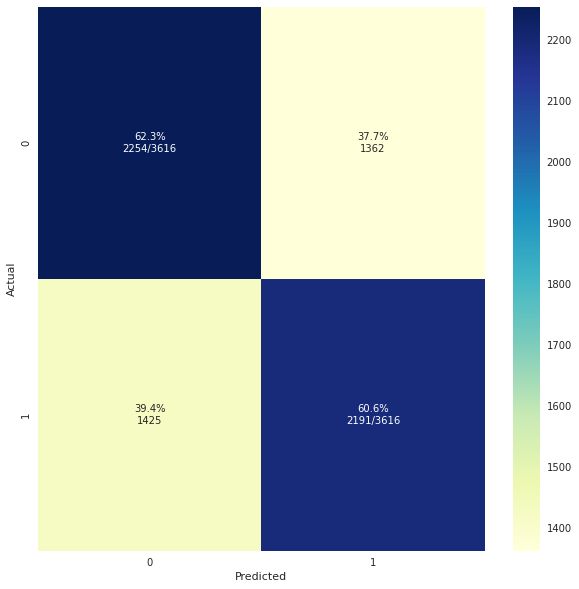

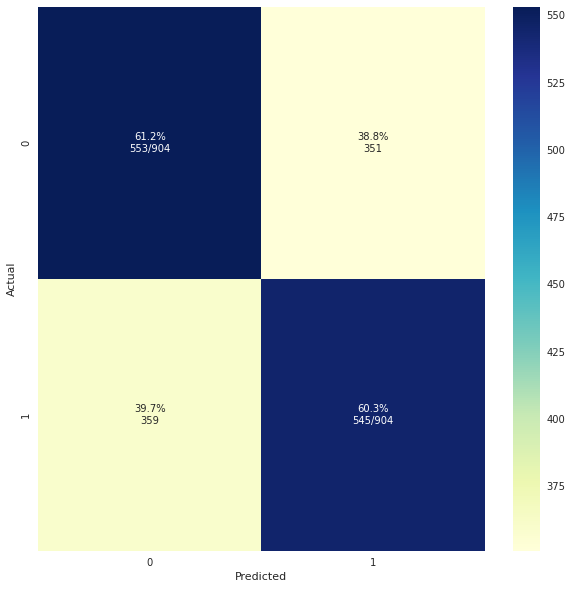

Train Accuracy Score After 10 K Fold CV 0.9227046460176991
Test Accuracy Score After 10 K Fold CV

 0.9214601769911505
Train Report:  
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      3616
           1       0.91      0.94      0.92      3616

    accuracy                           0.92      7232
   macro avg       0.92      0.92      0.92      7232
weighted avg       0.92      0.92      0.92      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       904
           1       0.92      0.93      0.92       904

    accuracy                           0.92      1808
   macro avg       0.92      0.92      0.92      1808
weighted avg       0.92      0.92      0.92      1808



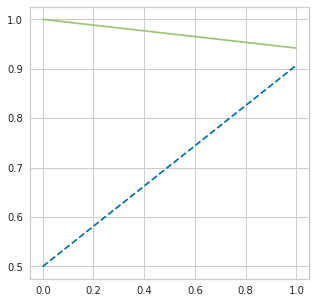

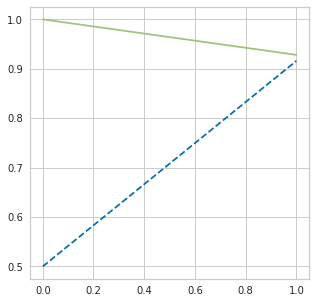

Train Log Loss:  2.6697255343277404
Test Log Loss:  2.7127034386501347


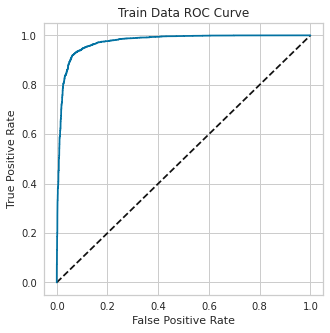

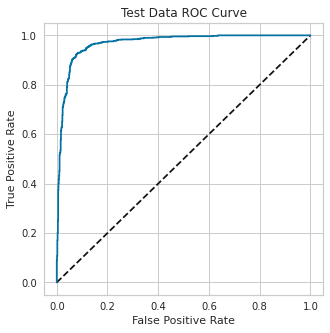

['gsr_st_binary_XGBoost.joblib']

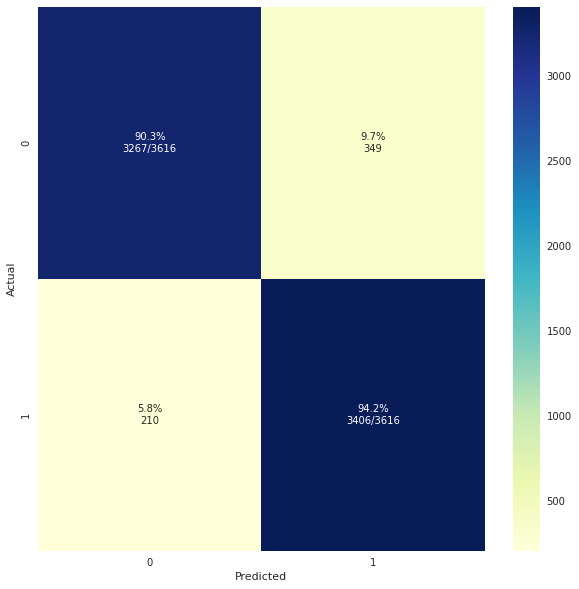

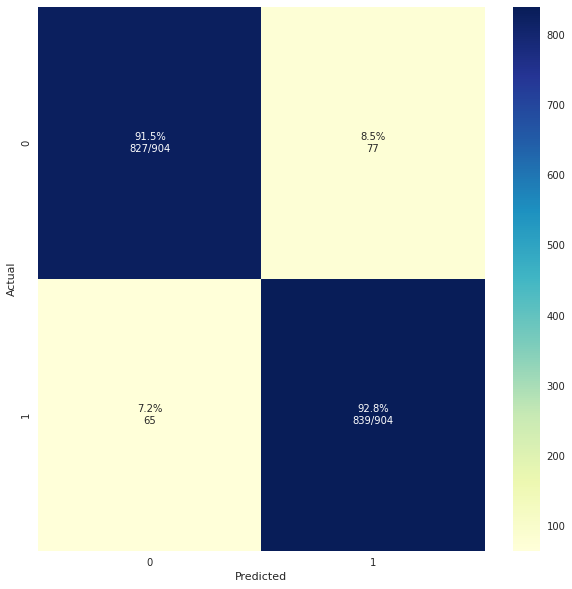

In [25]:
print("KNN Model : ")
xgboost_hyperpot_clf=knnhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'gsr_st_binary_knn.joblib') 
print("\n\n\nBernoulliNB Model")
xgboost_hyperpot_clf=nbhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'gsr_st_binary_nb.joblib') 
print("\n\n\nXGBoost Model")
xgboost_hyperpot_clf=xgboosthyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'gsr_st_binary_XGBoost.joblib') 



<a id="subsection-seven"></a>
## BVP+ GSR + ST Binary Class

In [26]:
ECGData=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-BVPBinary.csv')
otherdata2=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-GSRBinary.csv')
otherdata2['stress'] = otherdata2['stress'].replace([2],1)
otherdata=pd.read_csv('../input/affectiveroad-binaryclasses/BinaryClassCSV/csv_result-SkinTemperatureBinary.csv')
otherdata['stress'] = otherdata['stress'].replace([2],1)
temp=ECGData
temp =temp.drop(['csi','cvi','Modified_csi','sd2','ratio_sd2_sd1'],axis=1)
temp['stress'] = temp['stress'].replace([2],1)

ECGData=temp
temp=pd.merge(ECGData,otherdata,on=['id','stress'])
temp=pd.merge(temp,otherdata2,on=['id','stress'])
temp =temp.drop(['id'],axis=1)
ECGData=temp
corr_features = correlation(temp, 0.85)
temp=temp.drop(corr_features,axis=1)
from sklearn.model_selection import train_test_split
X = temp.drop(labels=['stress'],axis=1)
y = temp['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)



train shape: (7232, 23)
test shape: (1808, 23)


KNN Model : 
100%|██████████| 150/150 [02:06<00:00,  1.18trial/s, best loss: -0.755251484376791]
best:
{'n_neighbors': 4}
Train Accuracy KNN 0.8456858407079646
Test Accuracy KNN 0.7566371681415929 

Accuracies Train KNN:
 [0.75828729 0.72513812 0.74688797 0.71230982 0.73029046 0.73029046
 0.70677732 0.72475795 0.71507607 0.74550484]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7295320296798943
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.015651930379257006 

Accuracies Test KNN:
 [0.69060773 0.6961326  0.72928177 0.74033149 0.6519337  0.70165746
 0.77348066 0.6961326  0.70555556 0.71666667]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV KNN 0.7101780233271946
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV KNN 0.030963565436170078 

Train Accuracy Score After 10 K Fold CV 0.8456858407079646
Test Accuracy Score After 10 K Fold CV

 0.7566371681415929
Train Report:  
               precision    recall  f1-score   support

     

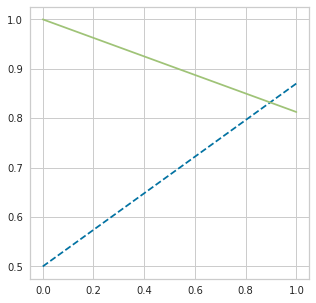

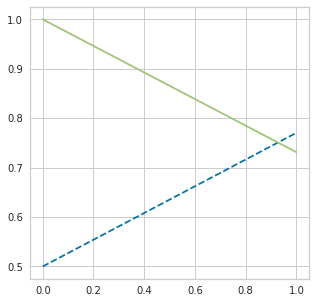

Train Log Loss:  5.329870669302371
Test Log Loss:  8.405541556667282


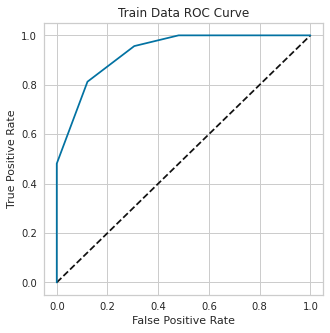

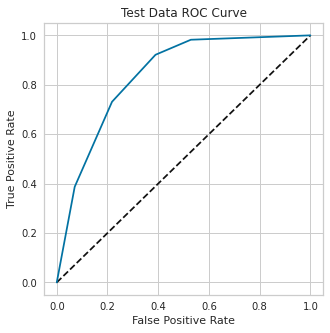




BernoulliNB Model
100%|██████████| 150/150 [00:18<00:00,  8.11trial/s, best loss: -0.6724249436760943]
best:
{'alpha': 0.19682591706343233}
Train Accuracy BernoulliNB 0.6722898230088495
Test Accuracy BernoulliNB 0.6963495575221239 

Accuracies Train BernoulliNB:
 [0.67403315 0.70027624 0.68049793 0.68049793 0.65006916 0.65836791
 0.65698479 0.66666667 0.66528354 0.69156293]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6724240235971971
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.015148686808344618 

Accuracies Test BernoulliNB:
 [0.65745856 0.71823204 0.71823204 0.70718232 0.62983425 0.70165746
 0.72375691 0.70718232 0.71666667 0.66111111]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.6941313689379989
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV BernoulliNB 0.03084452129607344 



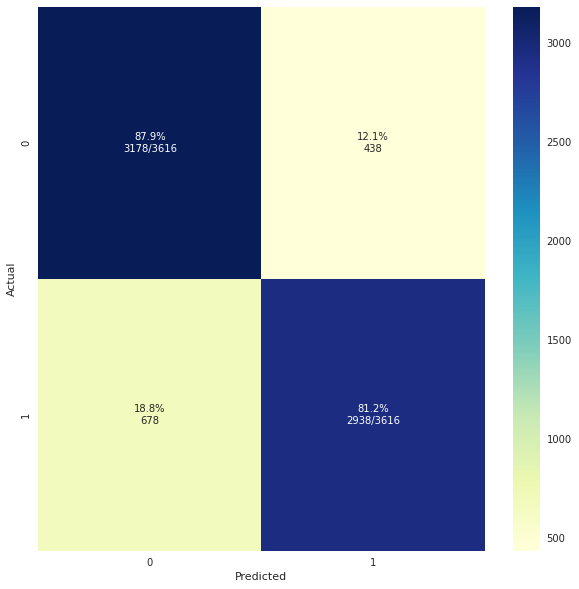

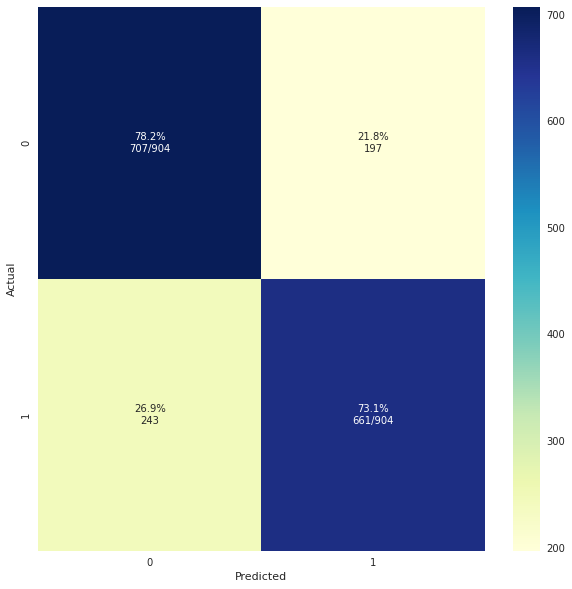

Train Accuracy Score After 10 K Fold CV 0.6722898230088495
Test Accuracy Score After 10 K Fold CV

 0.6963495575221239
Train Report:  
               precision    recall  f1-score   support

           0       0.73      0.55      0.63      3616
           1       0.64      0.80      0.71      3616

    accuracy                           0.67      7232
   macro avg       0.68      0.67      0.67      7232
weighted avg       0.68      0.67      0.67      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.76      0.58      0.66       904
           1       0.66      0.82      0.73       904

    accuracy                           0.70      1808
   macro avg       0.71      0.70      0.69      1808
weighted avg       0.71      0.70      0.69      1808



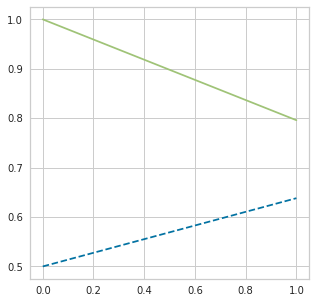

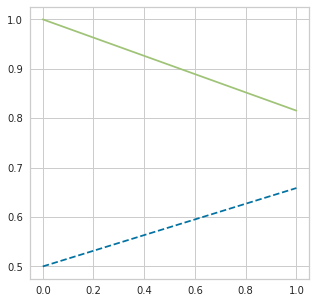

Train Log Loss:  11.318888965562001
Test Log Loss:  10.487883676451492


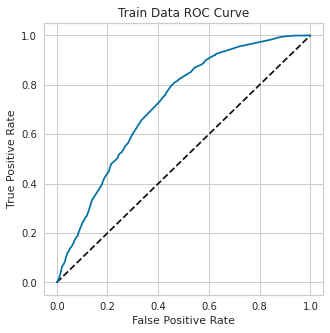

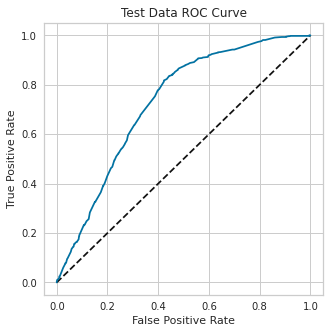




XGBoost Model
100%|██████████| 150/150 [18:44<00:00,  7.50s/trial, best loss: -0.8777654867256637]
The best hyperparameters are :  

{'colsample_bytree': 0.5942142113363302, 'gamma': 1.1879700567944378, 'max_depth': 18, 'min_child_weight': 2.0, 'reg_alpha': 40.0, 'reg_lambda': 0.8852310747188988} 

Train Accuracy XGBoost 0.9359789823008849
Test Accuracy XGBoost 0.9258849557522124 

Accuracies Train XGBoost:
 [0.92955801 0.92679558 0.91562932 0.9253112  0.88105118 0.90733057
 0.91701245 0.9142462  0.89626556 0.94467497]
Train Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.915787502961112
Train Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.017026833524578747 

Accuracies Test XGBoost:
 [0.77900552 0.82320442 0.82320442 0.80110497 0.80110497 0.82320442
 0.82872928 0.83977901 0.77777778 0.78333333]
Test Data Mean of the 'Accuracy' Metric 10 Fold CV XGBoost 0.8080448127685698
Test Data Standard Deviation of the 'Accuracy' Metric 10 Fold CV XGBoost 0.02142

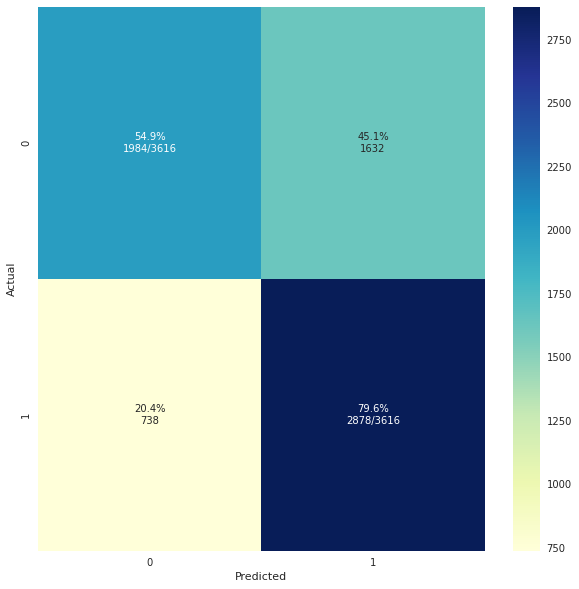

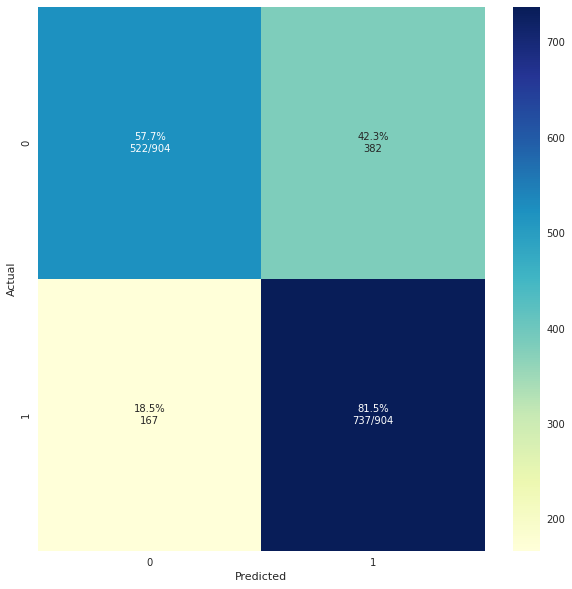

Train Accuracy Score After 10 K Fold CV 0.9359789823008849
Test Accuracy Score After 10 K Fold CV

 0.9258849557522124
Train Report:  
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      3616
           1       0.92      0.96      0.94      3616

    accuracy                           0.94      7232
   macro avg       0.94      0.94      0.94      7232
weighted avg       0.94      0.94      0.94      7232

Test Report:  
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       904
           1       0.91      0.95      0.93       904

    accuracy                           0.93      1808
   macro avg       0.93      0.93      0.93      1808
weighted avg       0.93      0.93      0.93      1808



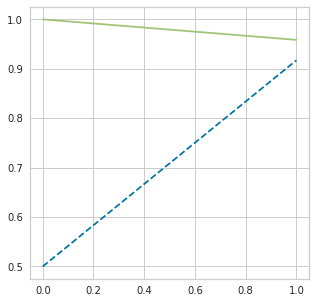

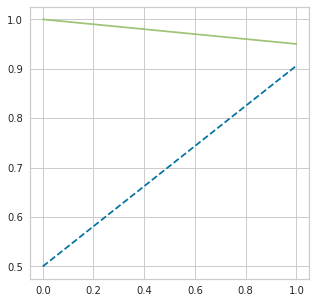

Train Log Loss:  2.211242221354992
Test Log Loss:  2.559882301487456


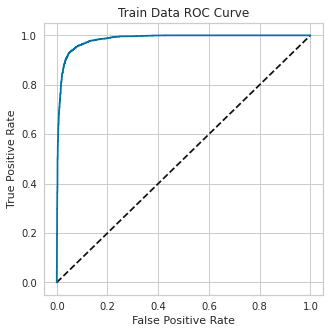

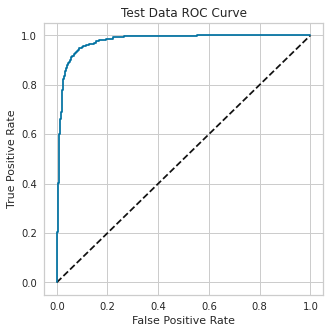

['bvp_gsr_st_binary_XGBoost.joblib']

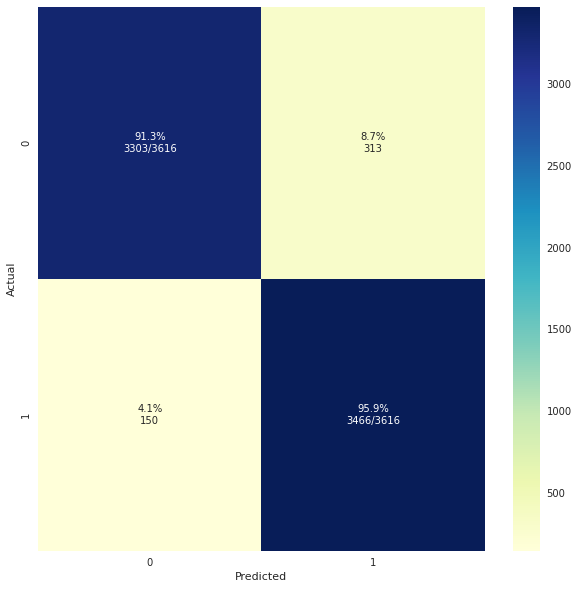

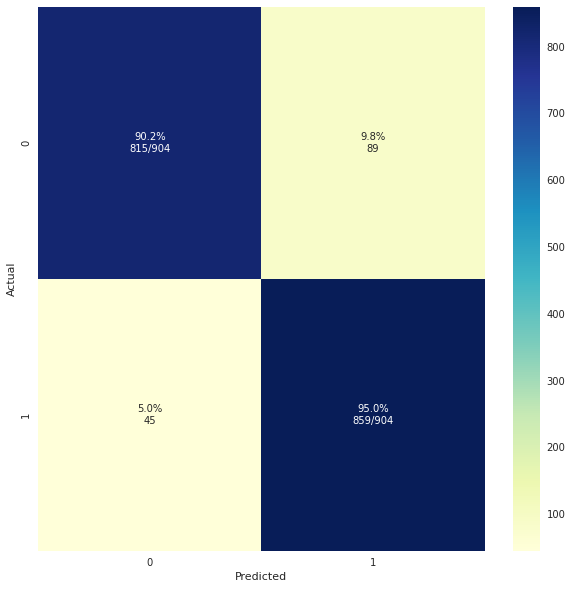

In [27]:
print("KNN Model : ")
xgboost_hyperpot_clf=knnhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_gsr_st_binary_knn.joblib') 
print("\n\n\nBernoulliNB Model")
xgboost_hyperpot_clf=nbhyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_gsr_st_binary_nb.joblib') 
print("\n\n\nXGBoost Model")
xgboost_hyperpot_clf=xgboosthyperopt(X_train, y_train,X_test,y_test)
dump(xgboost_hyperpot_clf, 'bvp_gsr_st_binary_XGBoost.joblib') 



https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce
Parameter Tuning with Hyperopt
